In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import phik
import shap
import time
import pickle

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.ticker as ticker
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

pd.set_option('display.max_columns', 140)
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import joblib
import mlflow
from mlflow import log_metric, log_param, log_artifacts



EDA, pre-processing and feature engineering based on a Kaggle Kernel : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features?scriptVersionId=6025993 and https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook

In [3]:
# Refer :- https://www.kaggle.com/rinnqd/reduce-memory-usage

def reduce_memory_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
PATH = "/Users/innakonar/Desktop/PythonScripts/Projet+Mise+en+prod+-+home-credit-default-risk/"
print(os.listdir(PATH))


['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


In [5]:
application_train = pd.read_csv(PATH+"application_train.csv")
application_test = pd.read_csv(PATH+"application_test.csv")

In [6]:
bureau_balance= reduce_memory_usage(pd.read_csv(PATH+'bureau_balance.csv', sep=','))
bureau= reduce_memory_usage(pd.read_csv(PATH+'bureau.csv', sep=','))
credit_card_balance= reduce_memory_usage(pd.read_csv(PATH+'credit_card_balance.csv', sep=','))
HomeCredit_columns_description= reduce_memory_usage(pd.read_csv(PATH+'HomeCredit_columns_description.csv', sep=',', encoding='ISO-8859-1'))
installments_payments= reduce_memory_usage(pd.read_csv(PATH+'installments_payments.csv', sep=',', encoding='ISO-8859-1'))
POS_CASH_balance= reduce_memory_usage(pd.read_csv(PATH+'POS_CASH_balance.csv', sep=',', encoding='ISO-8859-1'))
previous_application=reduce_memory_usage(pd.read_csv(PATH+'previous_application.csv', sep=',', encoding='ISO-8859-1'))
sample_submission= reduce_memory_usage(pd.read_csv(PATH+'sample_submission.csv', sep=',', encoding='ISO-8859-1'))

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 14.8%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage of dataframe is 0.74 MB
Memory usage after optimization is: 0.28 MB
Decreased by 62.5%


In [7]:
application_test

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY   
0          100001         Cash loans           F            N               Y  \
1          100005         Cash loans           M            N               Y   
2          100013         Cash loans           M            Y               Y   
3          100028         Cash loans           F            N               Y   
4          100038         Cash loans           M            Y               N   
...           ...                ...         ...          ...             ...   
48739      456221         Cash loans           F            N               Y   
48740      456222         Cash loans           F            N               N   
48741      456223         Cash loans           F            Y               Y   
48742      456224         Cash loans           M            N               N   
48743      456250         Cash loans           F            Y               N   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                 0          135000.0    568800.0      20560.5  \
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 1          180000.0    625500.0      32067.0   
...             ...               ...         ...          ...   
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE   
0             450000.0   Unaccompanied               Working  \
1             180000.0   Unaccompanied               Working   
2             630000.0             NaN               Working   
3            1575000.0   Unaccompanied               Working   
4             625500.0   Unaccompanied               Working   
...                ...             ...                   ...   
48739         270000.0   Unaccompanied               Working   
48740         495000.0   Unaccompanied  Commercial associate   
48741         315000.0   Unaccompanied  Commercial associate   
48742         450000.0          Family  Commercial associate   
48743         270000.0   Unaccompanied               Working   

                 NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE   
0                   Higher education            Married  House / apartment  \
1      Secondary / secondary special            Married  House / apartment   
2                   Higher education            Married  House / apartment   
3      Secondary / secondary special            Married  House / apartment   
4      Secondary / secondary special            Married  House / apartment   
...                              ...                ...                ...   
48739  Secondary / secondary special              Widow  House / apartment   
48740  Secondary / secondary special            Married  House / apartment   
48741  Secondary / secondary special            Married  House / apartment   
48742               Higher education            Married  House / apartment   
48743  Secondary / secondary special            Married  House / apartment   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED   
0                        0.018850      -19241          -2329  \
1                        0.035792      -18064          -4469   
2                        0.019101      -20038          -4458   
3                        0.026392      -13976          -1866   
4                        0.010032      -13040          -2191   
...                           ...         ...            ...   
48739                    0.002042      -19970          -5169   
48740                  

In [156]:
print(application_test.dtypes.sample(40))

ELEVATORS_MEDI                  float16
FLAG_DOCUMENT_17                   int8
ELEVATORS_AVG                   float16
FLAG_DOCUMENT_18                   int8
FLAG_DOCUMENT_3                    int8
NAME_TYPE_SUITE                  object
YEARS_BEGINEXPLUATATION_MEDI    float16
FLAG_DOCUMENT_7                    int8
BASEMENTAREA_MODE               float16
ELEVATORS_MODE                  float16
FONDKAPREMONT_MODE               object
COMMONAREA_MEDI                 float16
AMT_INCOME_TOTAL                float32
OCCUPATION_TYPE                  object
OWN_CAR_AGE                     float16
LIVINGAREA_AVG                  float16
WEEKDAY_APPR_PROCESS_START       object
NONLIVINGAPARTMENTS_MEDI        float16
OBS_60_CNT_SOCIAL_CIRCLE        float16
NAME_INCOME_TYPE                 object
REG_CITY_NOT_WORK_CITY             int8
REGION_RATING_CLIENT               int8
NAME_HOUSING_TYPE                object
DAYS_EMPLOYED                     int32
REGION_RATING_CLIENT_W_CITY        int8


In [157]:
application_test.info(max_cols=121)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    SK_ID_CURR                    48744 non-null  int32  
 1    NAME_CONTRACT_TYPE            48744 non-null  object 
 2    CODE_GENDER                   48744 non-null  object 
 3    FLAG_OWN_CAR                  48744 non-null  object 
 4    FLAG_OWN_REALTY               48744 non-null  object 
 5    CNT_CHILDREN                  48744 non-null  int8   
 6    AMT_INCOME_TOTAL              48744 non-null  float32
 7    AMT_CREDIT                    48744 non-null  float32
 8    AMT_ANNUITY                   48720 non-null  float32
 9    AMT_GOODS_PRICE               48744 non-null  float32
 10   NAME_TYPE_SUITE               47833 non-null  object 
 11   NAME_INCOME_TYPE              48744 non-null  object 
 12   NAME_EDUCATION_TYPE           48744 non-null

In [121]:
application_test.shape

(48744, 121)

In [122]:
application_test.isna().sum()

SK_ID_CURR                       0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY     6049
AMT_REQ_CREDIT_BUREAU_WEEK    6049
AMT_REQ_CREDIT_BUREAU_MON     6049
AMT_REQ_CREDIT_BUREAU_QRT     6049
AMT_REQ_CREDIT_BUREAU_YEAR    6049
Length: 121, dtype: int64

<AxesSubplot:>

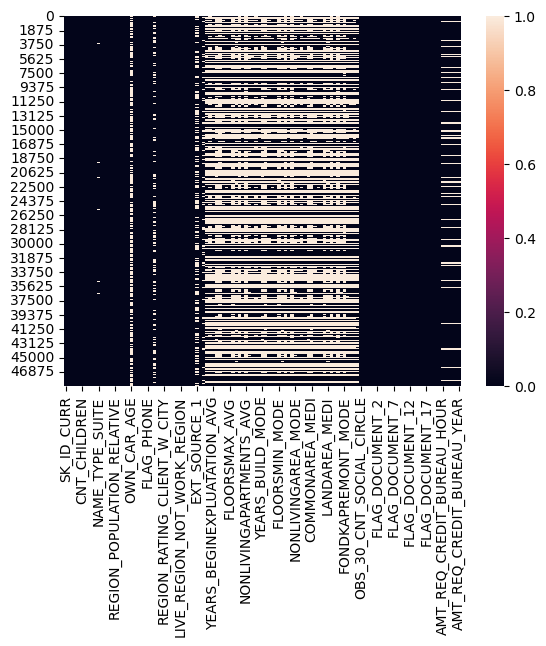

In [15]:
sns.heatmap(application_test.isna())

In [8]:
def missing_values_percentage(df):
   
    missing_percentage = (df.isnull().sum() / len(df)) * 100
   
    missing_percentage = missing_percentage[missing_percentage > 0]
    
    missing_percentage = missing_percentage.sort_values(ascending=False)
    print( missing_percentage)
   
    plt.figure(figsize=(20, 8))
    sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette='viridis')
    plt.xticks(rotation=90)
    plt.ylabel('Pourcentage de valeurs manquantes')
    plt.title('Les valeurs de la colonne de pourcentage sont manquantesх')
    plt.show()





COMMONAREA_MODE             68.716150
COMMONAREA_MEDI             68.716150
COMMONAREA_AVG              68.716150
NONLIVINGAPARTMENTS_MEDI    68.412523
NONLIVINGAPARTMENTS_AVG     68.412523
                              ...    
OBS_60_CNT_SOCIAL_CIRCLE     0.059495
DEF_30_CNT_SOCIAL_CIRCLE     0.059495
OBS_30_CNT_SOCIAL_CIRCLE     0.059495
AMT_ANNUITY                  0.049237
EXT_SOURCE_2                 0.016412
Length: 64, dtype: float64


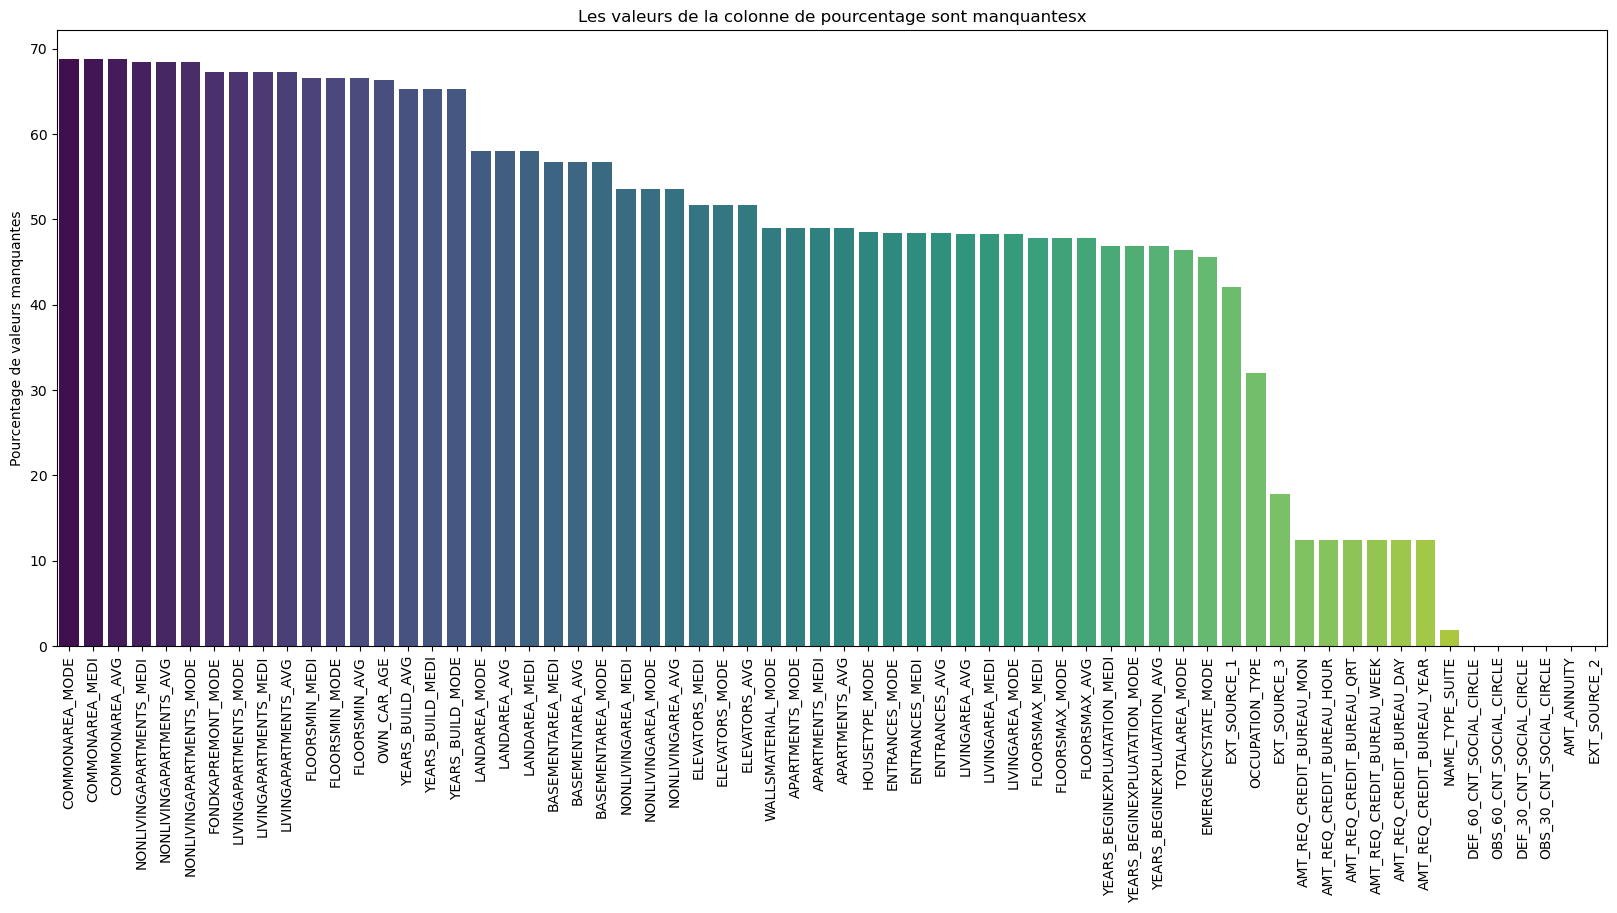

In [91]:
missing_values_percentage(application_test)

In [92]:
application_test.describe()

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT   
count   48744.000000  48744.000000      4.874400e+04  4.874400e+04  \
mean   277796.676350      0.397054      1.784318e+05  5.167404e+05   
std    103169.547296      0.709047      1.015237e+05  3.653976e+05   
min    100001.000000      0.000000      2.694150e+04  4.500000e+04   
25%    188557.750000      0.000000      1.125000e+05  2.606400e+05   
50%    277549.000000      0.000000      1.575000e+05  4.500000e+05   
75%    367555.500000      1.000000      2.250000e+05  6.750000e+05   
max    456250.000000     20.000000      4.410000e+06  2.245500e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE   
count   48720.000000     4.874400e+04                48744.000000  \
mean    29426.238281     4.626188e+05                    0.021240   
std     16016.254883     3.366994e+05                    0.014435   
min      2295.000000     4.500000e+04                    0.000253   
25%     17973.000000     2.250000e+05                    0.010010   
50%     26199.000000     3.960000e+05                    0.018845   
75%     37390.500000     6.300000e+05                    0.028656   
max    180576.000000     2.245500e+06                    0.072510   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH   
count  48744.000000   48744.000000            48744.0     48744.000000  \
mean  -16068.084605   67485.366322               -inf     -3051.712949   
std     4325.900393  144348.507136                inf      1569.276709   
min   -25195.000000  -17463.000000           -23728.0     -6348.000000   
25%   -19637.000000   -2910.000000            -7460.0     -4448.000000   
50%   -15785.000000   -1293.000000            -4488.0     -3234.000000   
75%   -12496.000000    -296.000000            -1901.0     -1706.000000   
max    -7338.000000  365243.000000                0.0         0.000000   

        OWN_CAR_AGE    FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE   
count  1.643200e+04  48744.000000    48744.000000     48744.000000  \
mean            inf      0.999979        0.809720         0.204702   
std    1.146094e+01      0.004529        0.392526         0.403488   
min    0.000000e+00      0.000000        0.000000         0.000000   
25%    4.000000e+00      1.000000        1.000000         0.000000   
50%    9.000000e+00      1.000000        1.000000         0.000000   
75%    1.500000e+01      1.000000        1.000000         0.000000   
max    7.400000e+01      1.000000        1.000000         1.000000   

       FLAG_CONT_MOBILE    FLAG_PHONE    FLAG_EMAIL  CNT_FAM_MEMBERS   
count      48744.000000  48744.000000  48744.000000     4.874400e+04  \
mean           0.998400      0.263130      0.162646              inf   
std            0.039971      0.440337      0.369046     8.906250e-01   
min            0.000000      0.000000      0.000000     1.000000e+00   
25%            1.000000      0.000000      0.000000     2.000000e+00   
50%            1.000000      0.000000      0.000000     2.000000e+00   
75%            1.000000      1.000000      0.000000     3.000000e+00   
max            1.000000      1.000000      1.000000     2.100000e+01   

       REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY   
count          48744.000000                 48744.000000  \
mean               2.038159                     2.012596   
std                0.522694                     0.515804   
min                1.000000                    -1.000000   
25%                2.000000                     2.000000   
50%                2.000000                     2.000000   
75%                2.000000                     2.000000   
max                3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION   
count             48744.000000                48744.000000  \
mean                 12.007365                    0.018833   
std                   3.278172                    0.135937   
min                  

In [93]:
application_train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR   
0           100002       1         Cash loans           M            N  \
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT   
0                    Y             0          202500.0    406597.5  \
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE   
0           24700.5         351000.0   Unaccompanied               Working  \
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS   
0       Secondary / secondary special  Single / not married  \
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH   
0       House / apartment                    0.018799       -9461  \
1       House / apartment                    0.003542      -16765   
2       House / apartment                    0.010033      -19046   
3       House / apartment                    0.008018      -19005   
4       House / apartment                    0.028656      -19932   
...                   ...                         ...         ...   
307506       With parents                    0.032562       -9327   
307507  House / apartment       

In [94]:
application_train.info(max_cols=122)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int32  
 1    TARGET                        307511 non-null  int8   
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int8   
 7    AMT_INCOME_TOTAL              307511 non-null  float32
 8    AMT_CREDIT                    307511 non-null  float32
 9    AMT_ANNUITY                   307499 non-null  float32
 10   AMT_GOODS_PRICE               307233 non-null  float32
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
                              ...    
EXT_SOURCE_2                 0.214626
AMT_GOODS_PRICE              0.090403
AMT_ANNUITY                  0.003902
CNT_FAM_MEMBERS              0.000650
DAYS_LAST_PHONE_CHANGE       0.000325
Length: 67, dtype: float64


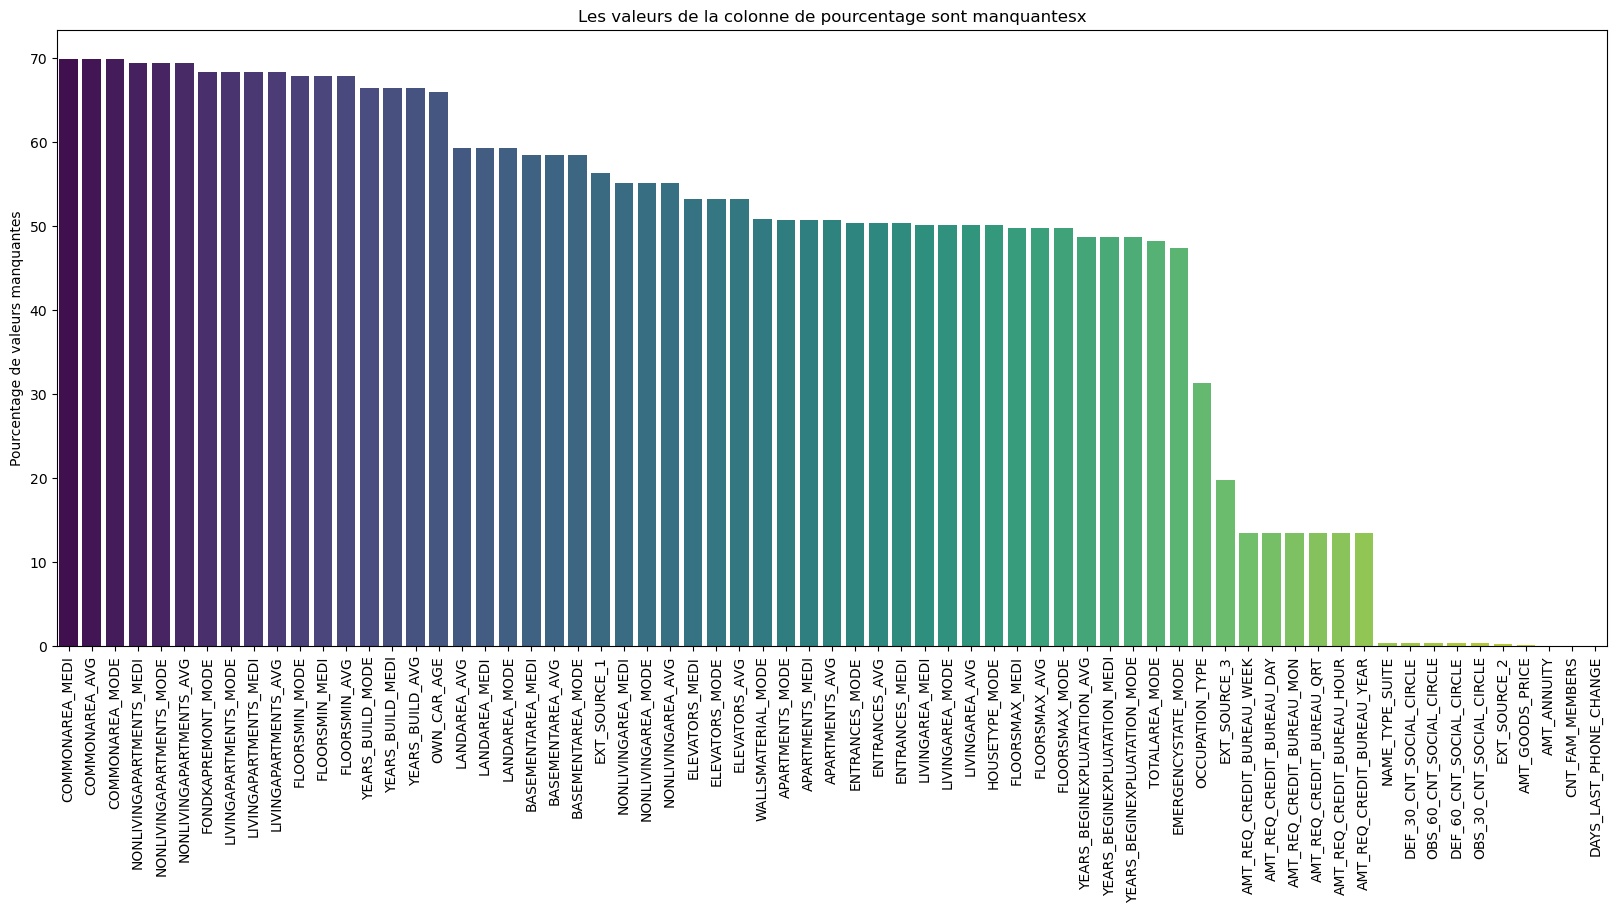

In [95]:
missing_values_percentage(application_train)

<AxesSubplot:>

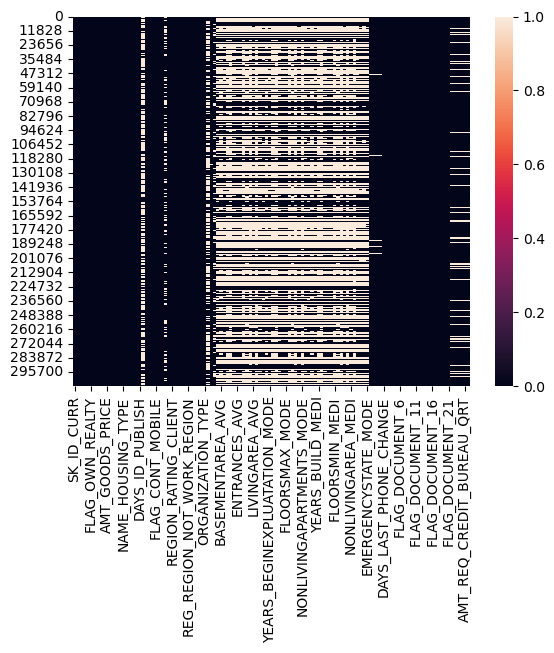

In [22]:
sns.heatmap(application_train.isna())

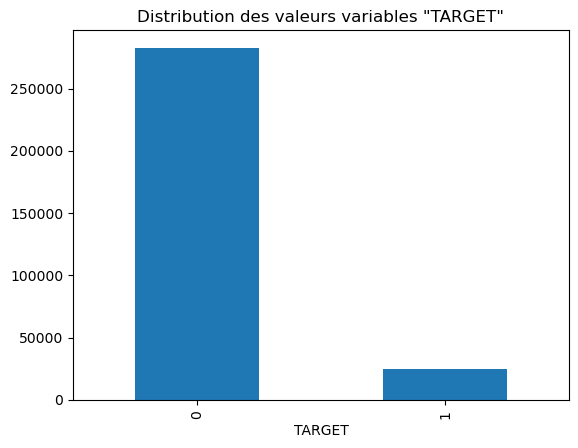

In [177]:
application_train["TARGET"].value_counts().plot(kind='bar')
plt.title('Distribution des valeurs variables "TARGET"')
plt.show()

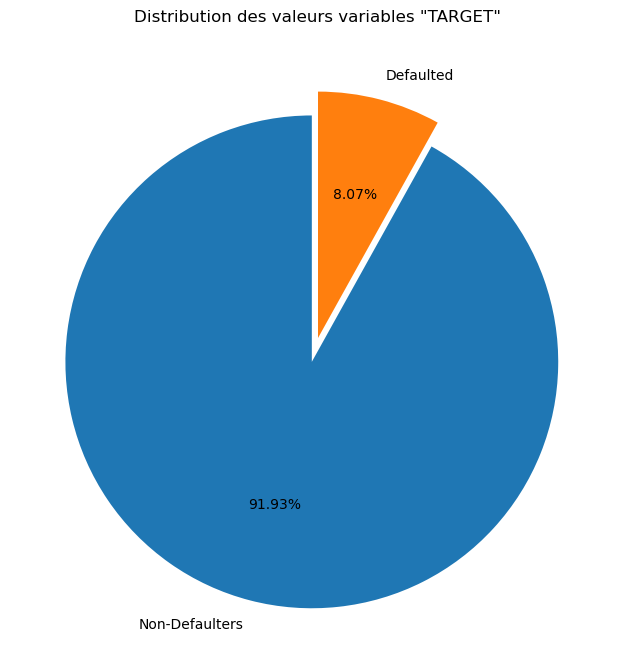

In [191]:
values = application_train["TARGET"].value_counts(normalize=True)
labels = ["Non-Defaulters", "Defaulted"]
sizes = values.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, explode=(0.1, 0))
plt.title('Distribution des valeurs variables "TARGET"')
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [192]:
application_train["TARGET"].value_counts(normalize = True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

In [99]:
""""
Nous constatons qu'environ 8,07% % des étiquettes de notre ensemble de données représentent des candidats 
qui n'ont pas remboursé leurs prêts.
"""

'"\nNous constatons qu\'environ 8,07% % des étiquettes de notre ensemble de données représentent des candidats \nqui n\'ont pas remboursé leurs prêts.\n'

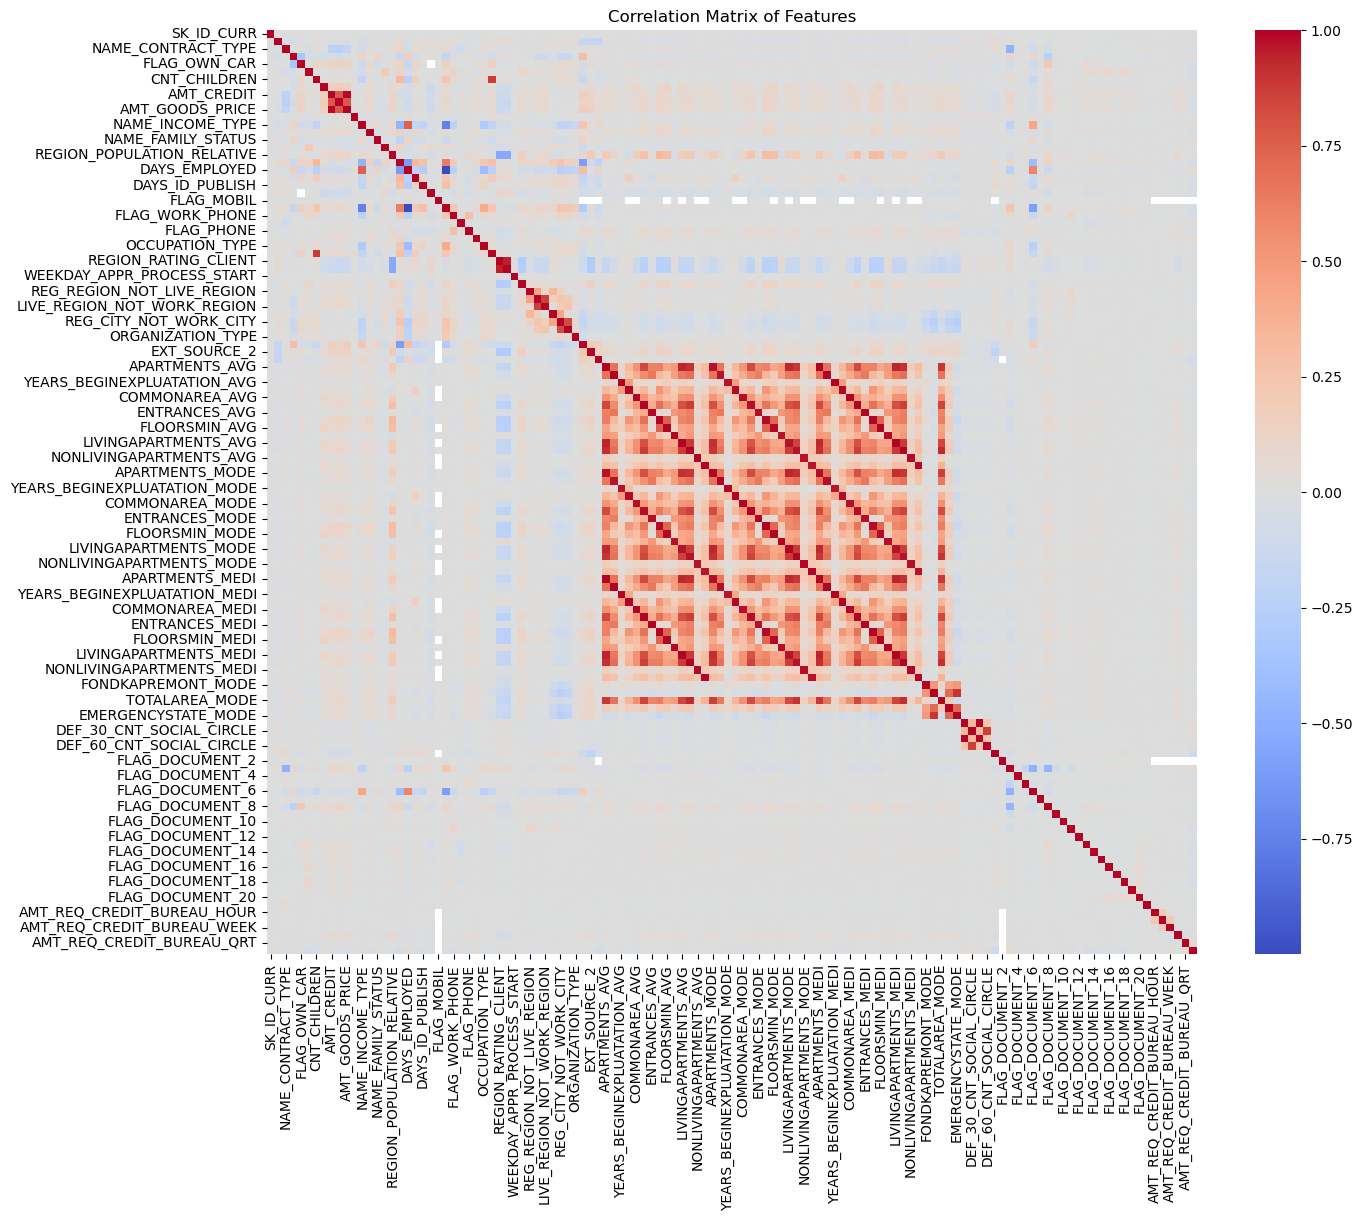

TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055219
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
OWN_CAR_AGE                    0.037612
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
FLAG_WORK_PHONE                0.028524
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
CNT_CHILDREN                   0.019187
OCCUPATION_TYPE                0.018785
NAME_HOUSING_TYPE              0.018335
Name: TARGET, dtype: float64


In [26]:
df_numeric = application_train.copy()

for col in df_numeric.columns:
    if df_numeric[col].dtype == 'object':
        df_numeric[col] = pd.factorize(df_numeric[col])[0]


corr_matrix = df_numeric.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)

plt.title("Correlation Matrix of Features")
plt.show()


target_corr = corr_matrix["TARGET"].sort_values(ascending=False)
print(target_corr.sort_values(ascending=False).head(20))



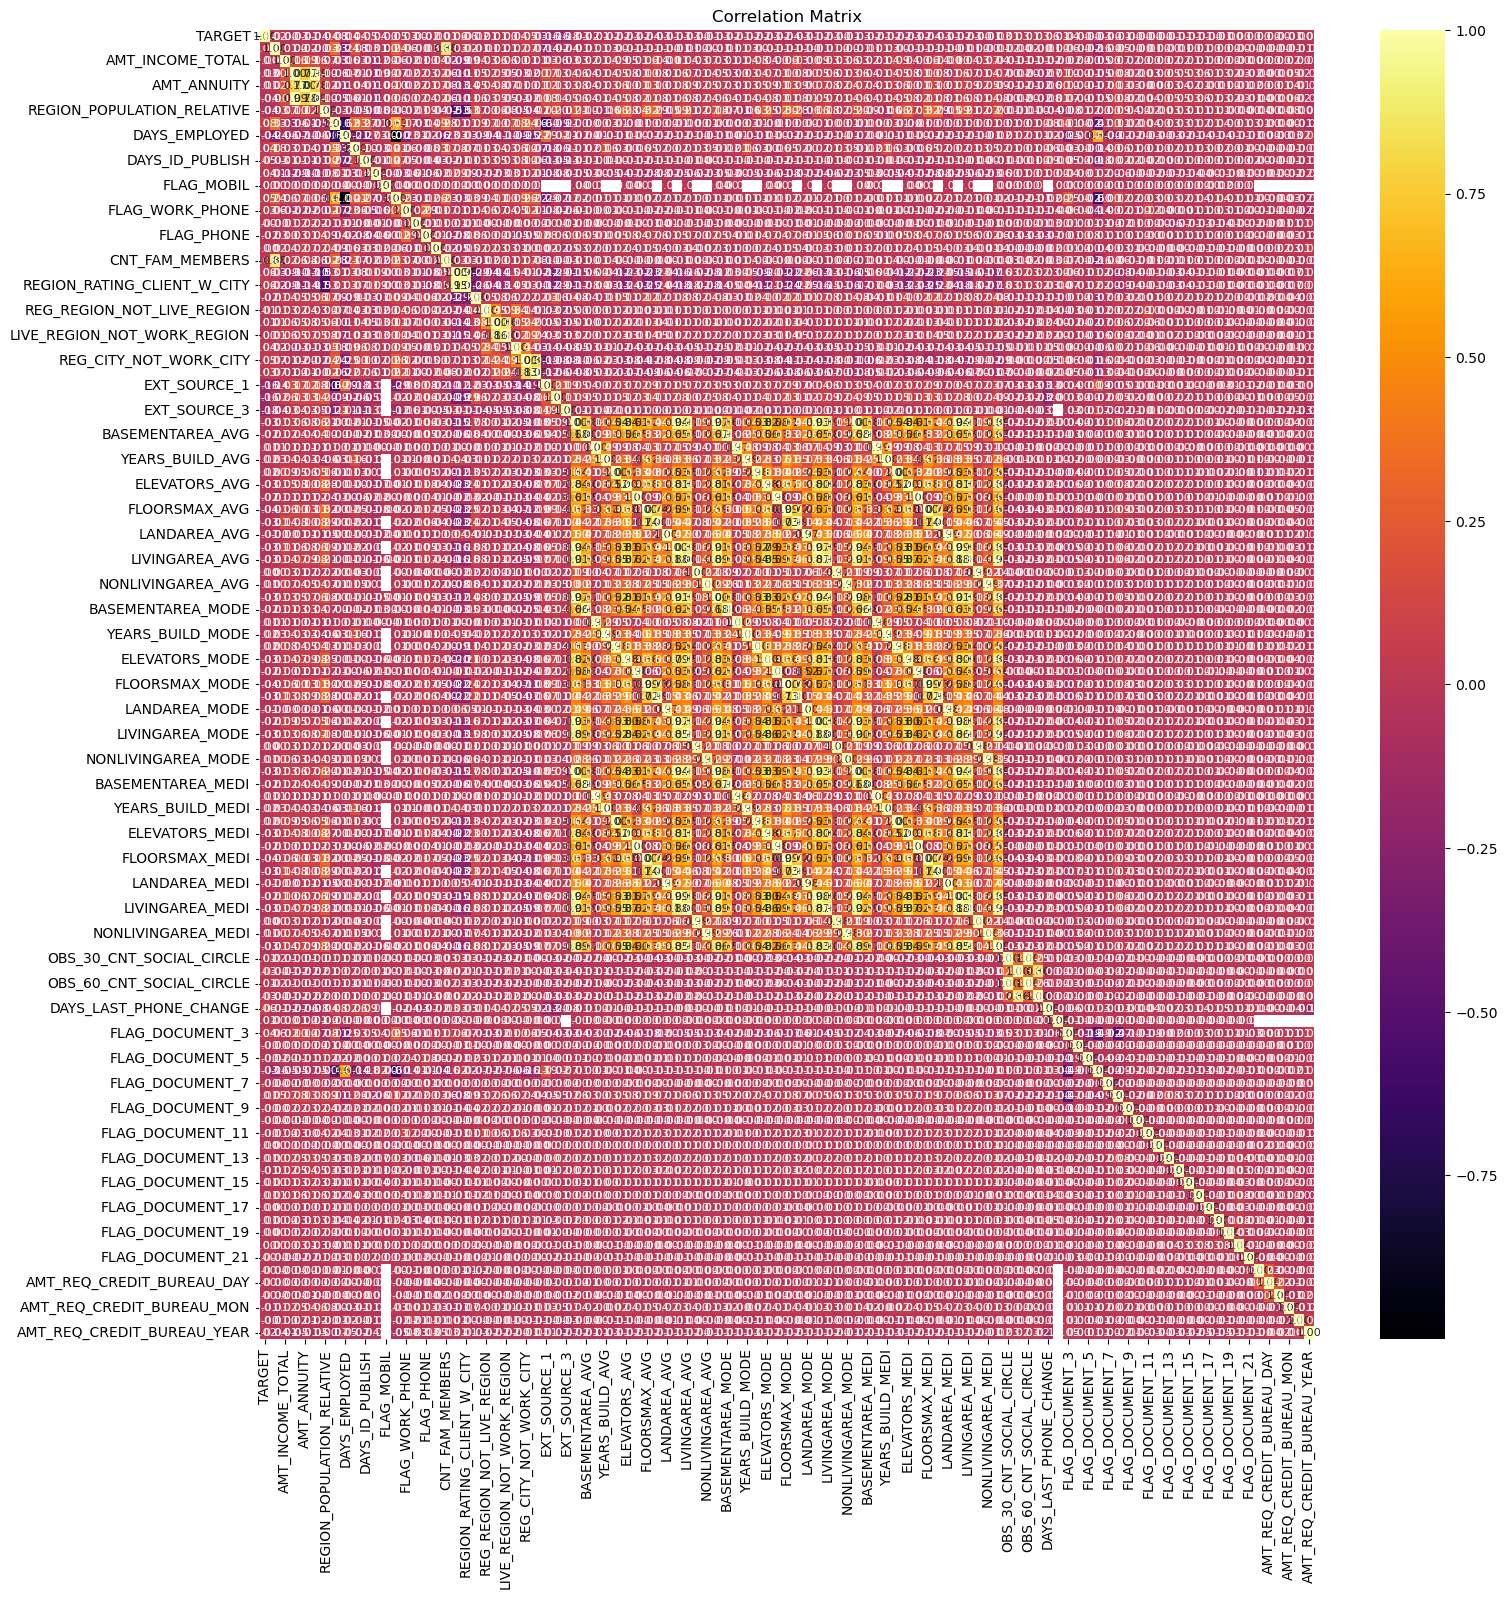

In [27]:
categorical_columns = application_train.select_dtypes(include=['object', 'category']).columns
columns_drop = ['SK_ID_CURR'] + list(categorical_columns)
df_numeric = application_train.drop(columns=columns_drop)

corr_matrix = df_numeric.corr()

plt.figure(figsize=(17, 17))
sns.heatmap(corr_matrix, cmap='inferno', annot=True, fmt=".2f", annot_kws={"size": 8})
plt.title("Correlation Matrix")
plt.show()




In [28]:
print(corr_matrix["TARGET"].sort_values(ascending=False).head(15))

print(corr_matrix["TARGET"].sort_values(ascending=True).head(10))


TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055219
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
OWN_CAR_AGE                    0.037612
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
Name: TARGET, dtype: float64
EXT_SOURCE_3                 -0.178918
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155318
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044005
FLOORSMAX_MEDI               -0.043769
FLOORSMAX_MODE               -0.043228
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037231
ELEVATORS_AVG       

Toutes les données sont faiblement corrélées à la cible (à l'exception de la cible elle-même, qui, bien entendu, est égale à elle-même). Cependant, l'âge et certaines « sources de données externes » ressortent des données.

In [100]:
# Calculer la corrélation Phik pour l'ensemble de données
correlation_matrix = application_train.phik_matrix()

# Sélectionnez les corrélations pour la colonne'TARGET'
target_correlation = correlation_matrix['TARGET'].sort_values(ascending=False)

print(target_correlation)


interval columns not set, guessing: ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', '

In [124]:
print(target_correlation.head(25))

TARGET                     1.000000
EXT_SOURCE_3               0.247680
EXT_SOURCE_1               0.217796
EXT_SOURCE_2               0.213959
OCCUPATION_TYPE            0.102846
DAYS_BIRTH                 0.102378
ORGANIZATION_TYPE          0.089164
NAME_INCOME_TYPE           0.084831
REG_CITY_NOT_WORK_CITY     0.079946
DAYS_LAST_PHONE_CHANGE     0.073217
DAYS_EMPLOYED              0.072095
FLAG_EMP_PHONE             0.072087
REG_CITY_NOT_LIVE_CITY     0.069588
FLAG_DOCUMENT_3            0.069525
DAYS_ID_PUBLISH            0.067766
AMT_GOODS_PRICE            0.059094
FLOORSMAX_AVG              0.058773
FLOORSMAX_MEDI             0.058595
FLOORSMAX_MODE             0.057678
AMT_CREDIT                 0.056794
NAME_FAMILY_STATUS         0.056043
OWN_CAR_AGE                0.055357
DAYS_REGISTRATION          0.054562
NAME_HOUSING_TYPE          0.051107
LIVE_CITY_NOT_WORK_CITY    0.050956
Name: TARGET, dtype: float64


In [102]:
print(target_correlation.tail(20))

FLAG_DOCUMENT_17               0.003790
AMT_INCOME_TOTAL               0.003358
LIVE_REGION_NOT_WORK_REGION    0.003343
AMT_REQ_CREDIT_BUREAU_DAY      0.003309
FLAG_DOCUMENT_4                0.001394
FLAG_DOCUMENT_12               0.000000
FLAG_DOCUMENT_10               0.000000
FLAG_DOCUMENT_7                0.000000
FLAG_DOCUMENT_5                0.000000
OBS_60_CNT_SOCIAL_CIRCLE       0.000000
OBS_30_CNT_SOCIAL_CIRCLE       0.000000
FLAG_DOCUMENT_19               0.000000
FLAG_DOCUMENT_20               0.000000
FLAG_MOBIL                     0.000000
AMT_REQ_CREDIT_BUREAU_HOUR     0.000000
FLAG_CONT_MOBILE               0.000000
AMT_REQ_CREDIT_BUREAU_WEEK     0.000000
FLAG_EMAIL                     0.000000
AMT_REQ_CREDIT_BUREAU_QRT      0.000000
SK_ID_CURR                     0.000000
Name: TARGET, dtype: float64


In [32]:
bureau_balance.sample(20)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
14819835       5464894             -59      C
75839          5726681             -11      X
8871331        5943698             -19      X
1626540        6023229             -56      C
23859464       6709832             -23      0
27038803       6709059             -89      X
22346627       5262675             -29      C
218716         6025418             -19      0
6884177        6778474             -43      0
13269669       5993487             -37      0
4296754        6019678             -24      X
5152044        6586646             -16      C
2069371        6321886               0      C
5322188        6580394             -29      C
6759925        6542257             -13      0
2943872        5010316             -42      X
15480554       6231196              -7      C
4424300        6564863             -29      C
15292400       5824306             -34      0
3697035        6362472             -74      C

In [103]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int32 
 1   MONTHS_BALANCE  int8  
 2   STATUS          object
dtypes: int32(1), int8(1), object(1)
memory usage: 338.5+ MB


In [104]:
bureau_balance.isna().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [105]:
bureau

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT   
0            215354       5714462        Closed      currency 1         -497  \
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT   
0                         0               -153.0             -153.0  \
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2432.0            -2492.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM   
0                           NaN                   0    9.132300e+04  \
1                           NaN                   0    2.250000e+05   
2                           NaN                   0    4.643235e+05   
3                           NaN                   0    9.000000e+04   
4                       77674.5                   0    2.700000e+06   
...                         ...                 ...             ...   
1716423                     0.0                   0    1.125000e+04   
1716424                  5476.5                   0    3.813084e+04   
1716425                     NaN                   0    1.557000e+04   
1716426                     NaN                   0    3.600000e+04   
1716427                     NaN                   0    2.250000e+04   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE   
0                        0.0                   NaN                     0.0  \
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
3            Credit card                 -16          NaN  
4        Consumer credit                 -21          NaN  
...                  ...                 ... 

In [106]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int32  
 1   SK_ID_BUREAU            int32  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int16  
 5   CREDIT_DAY_OVERDUE      int16  
 6   DAYS_CREDIT_ENDDATE     float16
 7   DAYS_ENDDATE_FACT       float16
 8   AMT_CREDIT_MAX_OVERDUE  float32
 9   CNT_CREDIT_PROLONG      int8   
 10  AMT_CREDIT_SUM          float32
 11  AMT_CREDIT_SUM_DEBT     float32
 12  AMT_CREDIT_SUM_LIMIT    float32
 13  AMT_CREDIT_SUM_OVERDUE  float32
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int32  
 16  AMT_ANNUITY             float32
dtypes: float16(2), float32(6), int16(2), int32(3), int8(1), object(3)
memory usage: 112.9+ MB


In [107]:
bureau.isna().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

AMT_ANNUITY               71.473490
AMT_CREDIT_MAX_OVERDUE    65.513264
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_DEBT       15.011932
DAYS_CREDIT_ENDDATE        6.149573
AMT_CREDIT_SUM             0.000757
dtype: float64


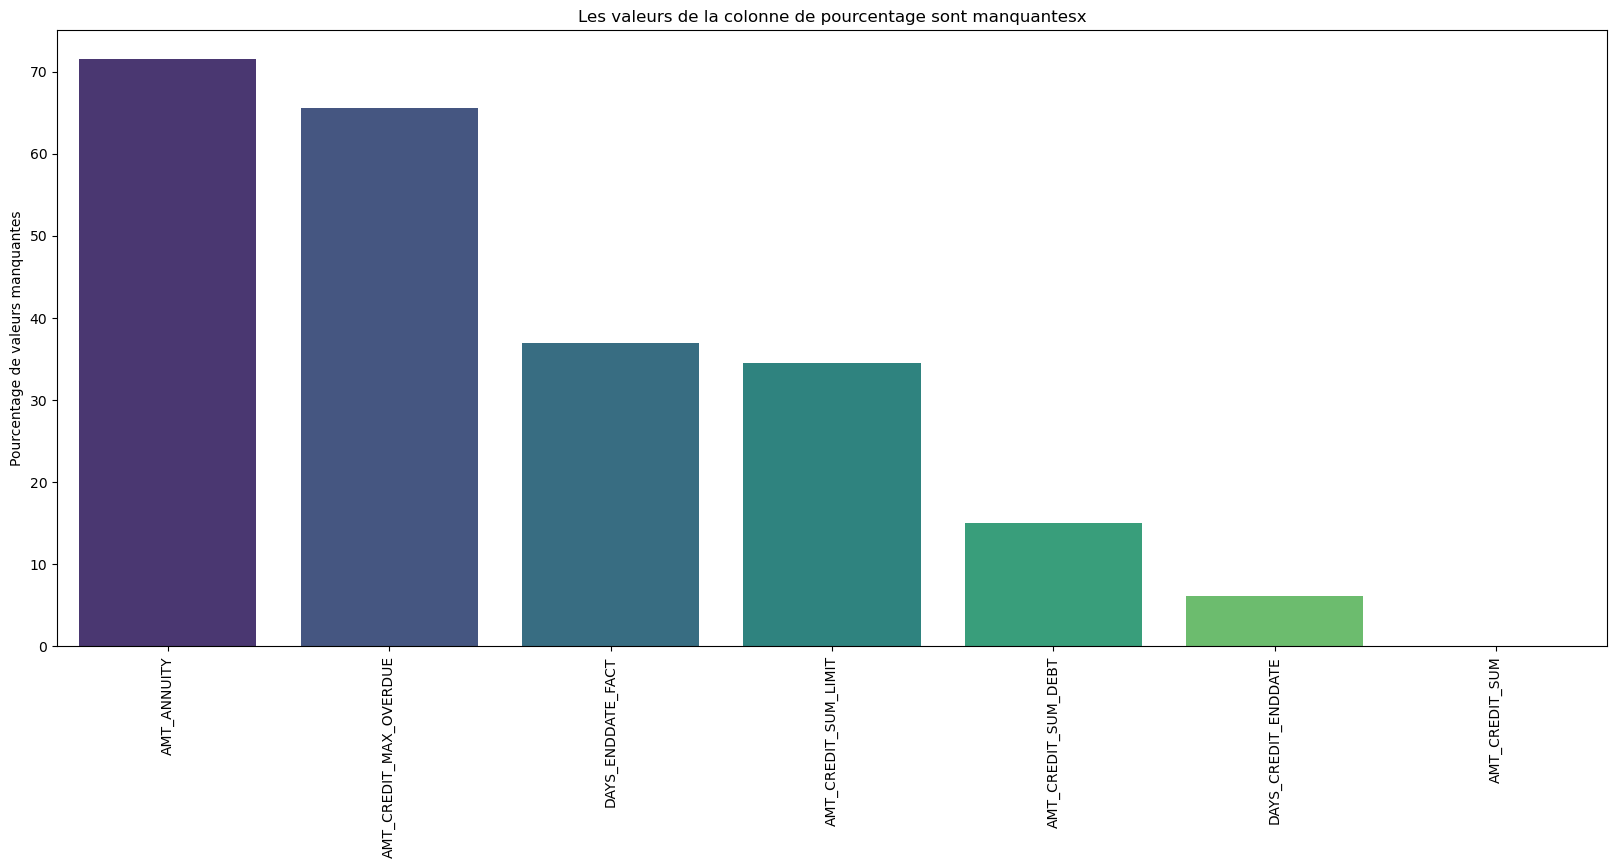

In [38]:
missing_values_percentage(bureau)

In [108]:
credit_card_balance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE    AMT_BALANCE   
0           2562384      378907              -6      56.970001  \
1           2582071      363914              -1   63975.554688   
2           1740877      371185              -7   31815.224609   
3           1389973      337855              -4  236572.109375   
4           1891521      126868              -1  453919.468750   
...             ...         ...             ...            ...   
3840307     1036507      328243              -9       0.000000   
3840308     1714892      347207              -9       0.000000   
3840309     1302323      215757              -9  275784.968750   
3840310     1624872      430337             -10       0.000000   
3840311     2411345      236760             -10       0.000000   

         AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT   
0                         135000                       0.0  \
1                          45000                    2250.0   
2                         450000                       0.0   
3                         225000                    2250.0   
4                         450000                       0.0   
...                          ...                       ...   
3840307                    45000                       NaN   
3840308                    45000                       0.0   
3840309                   585000                  270000.0   
3840310                   450000                       NaN   
3840311                   157500                       0.0   

         AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT   
0                       877.5                         0.0  \
1                      2250.0                         0.0   
2                         0.0                         0.0   
3                      2250.0                         0.0   
4                     11547.0                         0.0   
...                       ...                         ...   
3840307                   0.0                         NaN   
3840308                   0.0                         0.0   
3840309              270000.0                         0.0   
3840310                   0.0                         NaN   
3840311                   0.0                         0.0   

         AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY   
0                           877.5              1700.324951  \
1                             0.0              2250.000000   
2                             0.0              2250.000000   
3                             0.0             11795.759766   
4                         11547.0             22924.890625   
...                           ...                      ...   
3840307                       NaN                 0.000000   
3840308                       0.0                 0.000000   
3840309                       0.0              2250.000000   
3840310                       NaN                 0.000000   
3840311                       0.0                 0.000000   

         AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT   
0                1800.000000                  1800.0000  \
1                2250.000000                  2250.0000   
2                2250.000000                  2250.0000   
3               11925.000000                 11925.0000   
4               27000.000000                 27000.0000   
...                      ...                        ...   
3840307                  NaN                     0.0000   
3840308          1879.109985                     0.0000   
3840309        375750.000000                356994.6875   
3840310                  NaN                     0.0000   
3840311             0.000000                     0.0000   

         AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE   
0                        0.000000       0.000000              0.000000  \
1                    60175.078125   64875.554688          64875.554688   
2                    26926.425781   31460.085938          3146

In [40]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int32  
 1   SK_ID_CURR                  int32  
 2   MONTHS_BALANCE              int8   
 3   AMT_BALANCE                 float32
 4   AMT_CREDIT_LIMIT_ACTUAL     int32  
 5   AMT_DRAWINGS_ATM_CURRENT    float32
 6   AMT_DRAWINGS_CURRENT        float32
 7   AMT_DRAWINGS_OTHER_CURRENT  float32
 8   AMT_DRAWINGS_POS_CURRENT    float32
 9   AMT_INST_MIN_REGULARITY     float32
 10  AMT_PAYMENT_CURRENT         float32
 11  AMT_PAYMENT_TOTAL_CURRENT   float32
 12  AMT_RECEIVABLE_PRINCIPAL    float32
 13  AMT_RECIVABLE               float32
 14  AMT_TOTAL_RECEIVABLE        float32
 15  CNT_DRAWINGS_ATM_CURRENT    float16
 16  CNT_DRAWINGS_CURRENT        int16  
 17  CNT_DRAWINGS_OTHER_CURRENT  float16
 18  CNT_DRAWINGS_POS_CURRENT    float16
 19  CNT_INSTALMENT_MATURE

In [41]:
credit_card_balance.isna().sum()

SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

AMT_PAYMENT_CURRENT           19.998063
AMT_DRAWINGS_ATM_CURRENT      19.524872
AMT_DRAWINGS_OTHER_CURRENT    19.524872
AMT_DRAWINGS_POS_CURRENT      19.524872
CNT_DRAWINGS_ATM_CURRENT      19.524872
CNT_DRAWINGS_OTHER_CURRENT    19.524872
CNT_DRAWINGS_POS_CURRENT      19.524872
AMT_INST_MIN_REGULARITY        7.948208
CNT_INSTALMENT_MATURE_CUM      7.948208
dtype: float64


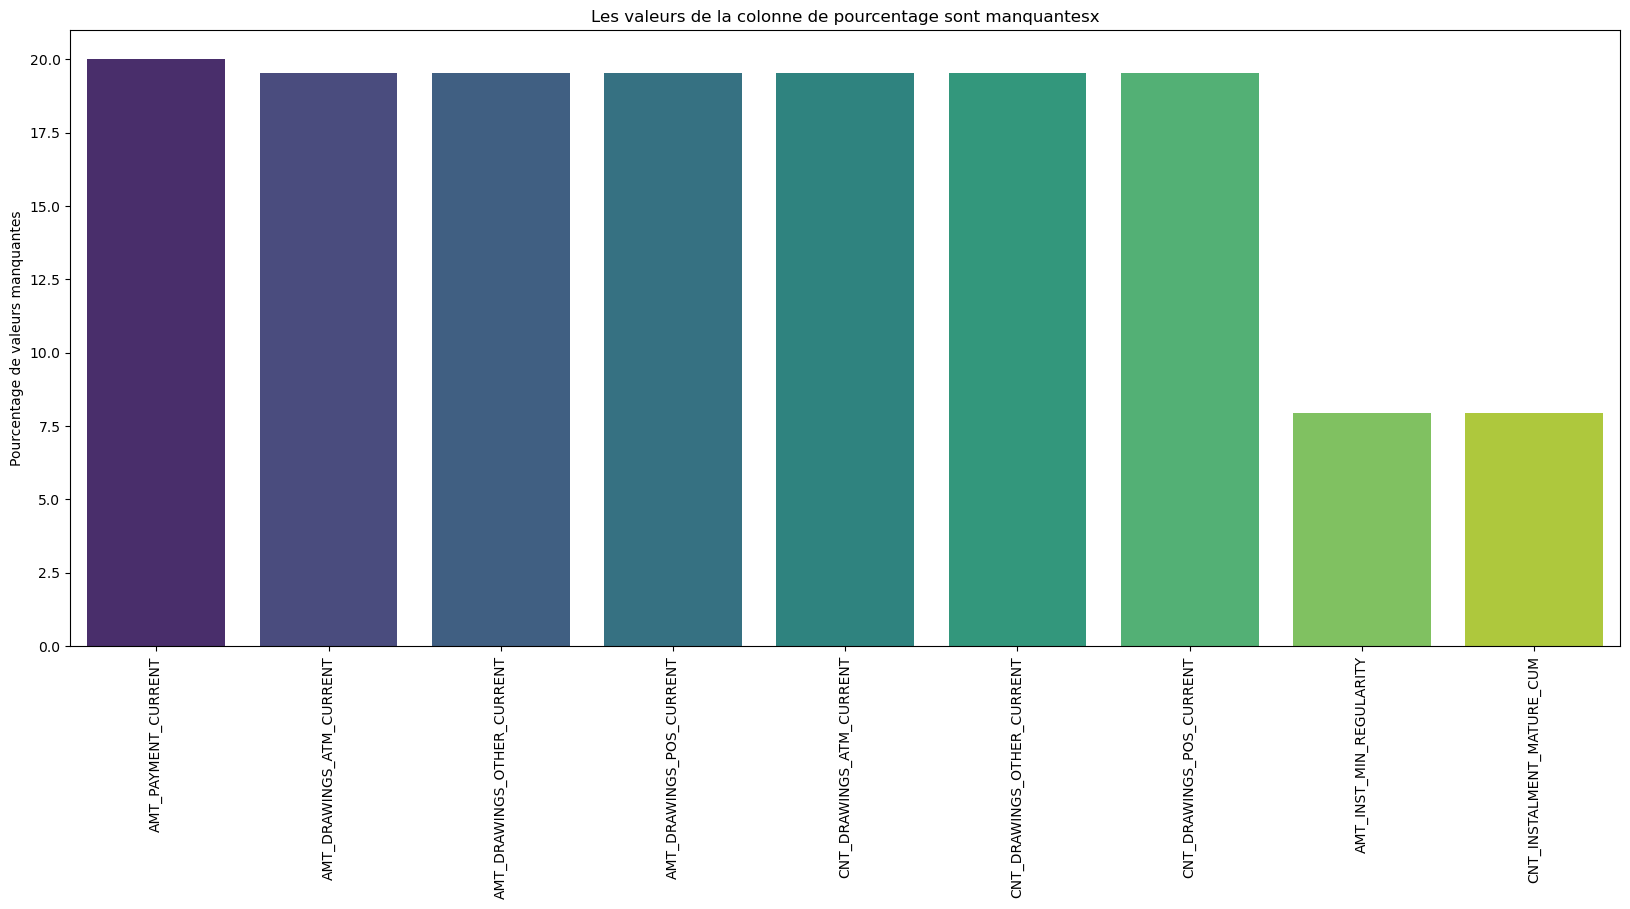

In [42]:
missing_values_percentage(credit_card_balance)

In [43]:
HomeCredit_columns_description.sample(30)

Unnamed: 0                         Table                         Row   
164         167       credit_card_balance.csv        AMT_TOTAL_RECEIVABLE  \
84           87  application_{train|test}.csv    NONLIVINGAPARTMENTS_MEDI   
193         196      previous_application.csv          CODE_REJECT_REASON   
98          101  application_{train|test}.csv             FLAG_DOCUMENT_4   
6             9  application_{train|test}.csv                CNT_CHILDREN   
99          102  application_{train|test}.csv             FLAG_DOCUMENT_5   
125         128                    bureau.csv             CREDIT_CURRENCY   
62           65  application_{train|test}.csv             COMMONAREA_MODE   
210         213      previous_application.csv   NFLAG_INSURED_ON_APPROVAL   
166         169       credit_card_balance.csv        CNT_DRAWINGS_CURRENT   
19           22  application_{train|test}.csv           DAYS_REGISTRATION   
14           17  application_{train|test}.csv          NAME_FAMILY_STATUS   
67           70  application_{train|test}.csv               LANDAREA_MODE   
129         132                    bureau.csv           DAYS_ENDDATE_FACT   
63           66  application_{train|test}.csv              ELEVATORS_MODE   
218         221     installments_payments.csv                 AMT_PAYMENT   
207         210      previous_application.csv   DAYS_LAST_DUE_1ST_VERSION   
204         207      previous_application.csv         PRODUCT_COMBINATION   
130         133                    bureau.csv      AMT_CREDIT_MAX_OVERDUE   
141         144            bureau_balance.csv                      STATUS   
131         134                    bureau.csv          CNT_CREDIT_PROLONG   
188         191      previous_application.csv    RATE_INTEREST_PRIVILEGED   
8            11  application_{train|test}.csv                  AMT_CREDIT   
185         188      previous_application.csv            NFLAG_MICRO_CASH   
75           78  application_{train|test}.csv            YEARS_BUILD_MEDI   
71           74  application_{train|test}.csv          NONLIVINGAREA_MODE   
32           35  application_{train|test}.csv  WEEKDAY_APPR_PROCESS_START   
196         199      previous_application.csv         NAME_GOODS_CATEGORY   
140         143            bureau_balance.csv              MONTHS_BALANCE   
21           24  application_{train|test}.csv                 OWN_CAR_AGE   

                                           Description   
164     Total amount receivable on the previous credit  \
84   Normalized information about building where th...   
193          Why was the previous application rejected   
98                       Did client provide document 4   
6                    Number of children the client has   
99                       Did client provide document 5   
125       Recoded currency of the Credit Bureau credit   
62   Normalized information about building where th...   
210  Did the client requested insurance during the ...   
166  Number of drawings during this month on the pr...   
19   How many days before the application did clien...   
14                         Family status of the client   
67   Normalized information about building where th...   
129  Days since CB credit ended at the time of appl...   
63   Normalized information about building where th...   
218  What the client actually paid on previous cred...   
207  Relative to application date of current applic...   
204  Detailed product combination of the previous a...   
130  Maximal amount overdue on the Credit Bureau cr...   
141  Status of Credit Bureau loan during the month ...   
131  How many times was the Credit Bureau credit pr...   
188        Interest rate normalized on previous credit   
8                            Credit amount of the loan   
185                            Flag Micro finance loan   
75   Normalized information about building where th...   
71   Normalized information about building where th...   
32   On which day of the week did the client apply 

In [44]:
HomeCredit_columns_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int16 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int16(1), object(4)
memory usage: 7.4+ KB


In [45]:
installments_payments

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION   
0            1054186      161674                     1.0  \
1            1330831      151639                     0.0   
2            2085231      193053                     2.0   
3            2452527      199697                     1.0   
4            2714724      167756                     1.0   
...              ...         ...                     ...   
13605396     2186857      428057                     0.0   
13605397     1310347      414406                     0.0   
13605398     1308766      402199                     0.0   
13605399     1062206      409297                     0.0   
13605400     2448869      434321                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT   
0                             6          -1180.0             -1187.0  \
1                            34          -2156.0             -2156.0   
2                             1            -63.0               -63.0   
3                             3          -2418.0             -2426.0   
4                             2          -1383.0             -1366.0   
...                         ...              ...                 ...   
13605396                     66          -1624.0                 NaN   
13605397                     47          -1539.0                 NaN   
13605398                     43             -7.0                 NaN   
13605399                     43          -1986.0                 NaN   
13605400                     19            -27.0                 NaN   

          AMT_INSTALMENT   AMT_PAYMENT  
0            6948.359863   6948.359863  
1            1716.525024   1716.525024  
2           25425.000000  25425.000000  
3           24350.130859  24350.130859  
4            2165.040039   2160.584961  
...                  ...           ...  
13605396       67.500000           NaN  
13605397       67.500000           NaN  
13605398    43737.433594           NaN  
13605399       67.500000           NaN  
13605400    11504.250000           NaN  

[13605401 rows x 8 columns]

In [46]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int32  
 1   SK_ID_CURR              int32  
 2   NUM_INSTALMENT_VERSION  float16
 3   NUM_INSTALMENT_NUMBER   int16  
 4   DAYS_INSTALMENT         float16
 5   DAYS_ENTRY_PAYMENT      float16
 6   AMT_INSTALMENT          float32
 7   AMT_PAYMENT             float32
dtypes: float16(3), float32(2), int16(1), int32(2)
memory usage: 311.4 MB


In [47]:
installments_payments.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [48]:
POS_CASH_balance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT   
0            1803195      182943             -31            48.0  \
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          45.0               Active       0           0  
1                          35.0               Active       0           0  
2                           9.0               Active       0           0  
3                          42.0               Active       0           0  
4                          35.0               Active       0           0  
...                         ...                  ...     ...         ...  
10001353                    0.0               Active     843           0  
10001354                    0.0               Active     602           0  
10001355                    0.0               Active     609           0  
10001356                    0.0               Active     614           0  
10001357                    0.0            Completed       0           0  

[10001358 rows x 8 columns]

In [49]:
POS_CASH_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int32  
 1   SK_ID_CURR             int32  
 2   MONTHS_BALANCE         int8   
 3   CNT_INSTALMENT         float16
 4   CNT_INSTALMENT_FUTURE  float16
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int16  
 7   SK_DPD_DEF             int16  
dtypes: float16(2), int16(2), int32(2), int8(1), object(1)
memory usage: 238.5+ MB


In [50]:
POS_CASH_balance.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

In [51]:
previous_application

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE   AMT_ANNUITY   
0           2030495      271877     Consumer loans   1730.430054  \
1           2802425      108129         Cash loans  25188.615234   
2           2523466      122040         Cash loans  15060.735352   
3           2819243      176158         Cash loans  47041.335938   
4           1784265      202054         Cash loans  31924.394531   
...             ...         ...                ...           ...   
1670209     2300464      352015     Consumer loans  14704.290039   
1670210     2357031      334635     Consumer loans   6622.020020   
1670211     2659632      249544     Consumer loans  11520.855469   
1670212     2785582      400317         Cash loans  18821.519531   
1670213     2418762      261212         Cash loans  16431.300781   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE   
0                17145.0     17145.0               0.0          17145.0  \
1               607500.0    679671.0               NaN         607500.0   
2               112500.0    136444.5               NaN         112500.0   
3               450000.0    470790.0               NaN         450000.0   
4               337500.0    404055.0               NaN         337500.0   
...                  ...         ...               ...              ...   
1670209         267295.5    311400.0               0.0         267295.5   
1670210          87750.0     64291.5           29250.0          87750.0   
1670211         105237.0    102523.5           10525.5         105237.0   
1670212         180000.0    191880.0               NaN         180000.0   
1670213         360000.0    360000.0               NaN         360000.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START   
0                         SATURDAY                       15  \
1                         THURSDAY                       11   
2                          TUESDAY                       11   
3                           MONDAY                        7   
4                         THURSDAY                        9   
...                            ...                      ...   
1670209                  WEDNESDAY                       12   
1670210                    TUESDAY                       15   
1670211                     MONDAY                       12   
1670212                  WEDNESDAY                        9   
1670213                     SUNDAY                       10   

        FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY   
0                                 Y                       1  \
1                                 Y                       1   
2                                 Y                       1   
3                                 Y                       1   
4                                 Y                       1   
...                             ...                     ...   
1670209                           Y                       1   
1670210                           Y                       1   
1670211                           Y                       1   
1670212                           Y                       1   
1670213                           Y                       1   

         RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED   
0                 0.000000               0.182861                  0.867188  \
1                      NaN                    NaN                       NaN   
2                      NaN                    NaN                       NaN   
3                      NaN                    NaN                       NaN   
4                      NaN                    NaN                       NaN   
...                    ...                    ...                       ...   
1670209           0.000000                    NaN                       NaN   
1670210           0.340576                    NaN                       NaN   
1670211           0.101379                    NaN                 

In [52]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int32  
 1   SK_ID_CURR                   1670214 non-null  int32  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float32
 4   AMT_APPLICATION              1670214 non-null  float32
 5   AMT_CREDIT                   1670213 non-null  float32
 6   AMT_DOWN_PAYMENT             774370 non-null   float32
 7   AMT_GOODS_PRICE              1284699 non-null  float32
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int8   
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int8   
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [53]:
previous_application.isna().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

RATE_INTEREST_PRIMARY        99.643698
RATE_INTEREST_PRIVILEGED     99.643698
AMT_DOWN_PAYMENT             53.636480
RATE_DOWN_PAYMENT            53.636480
NAME_TYPE_SUITE              49.119754
DAYS_FIRST_DRAWING           40.298129
DAYS_FIRST_DUE               40.298129
DAYS_LAST_DUE_1ST_VERSION    40.298129
DAYS_LAST_DUE                40.298129
DAYS_TERMINATION             40.298129
NFLAG_INSURED_ON_APPROVAL    40.298129
AMT_GOODS_PRICE              23.081773
AMT_ANNUITY                  22.286665
CNT_PAYMENT                  22.286366
PRODUCT_COMBINATION           0.020716
AMT_CREDIT                    0.000060
dtype: float64


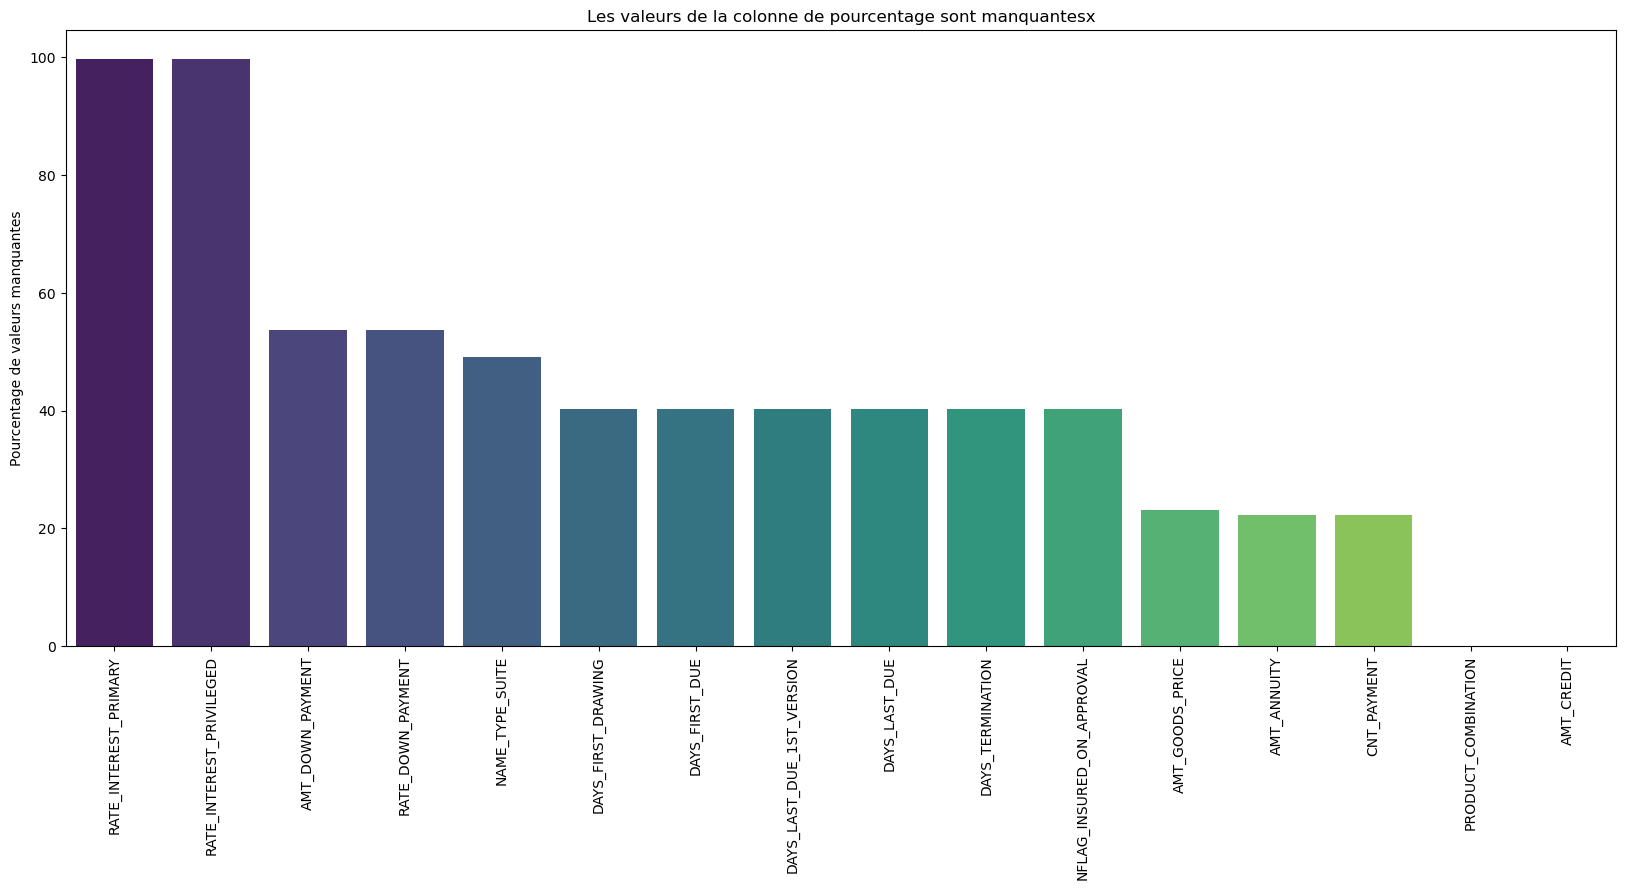

In [54]:
missing_values_percentage(previous_application)

In [55]:
sample_submission

SK_ID_CURR  TARGET
0          100001     0.5
1          100005     0.5
2          100013     0.5
3          100028     0.5
4          100038     0.5
...           ...     ...
48739      456221     0.5
48740      456222     0.5
48741      456223     0.5
48742      456224     0.5
48743      456250     0.5

[48744 rows x 2 columns]

In [56]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int32  
 1   TARGET      48744 non-null  float16
dtypes: float16(1), int32(1)
memory usage: 285.7 KB


In [ ]:
""""
1.application_test : tester l'ensemble de données sur les clients de la banque;

2.application_train : ensemble de données de formation sur les clients de la banque. 
Il contient les mêmes colonnes que application_test, plus une colonne TARGET supplémentaire 
qui indique si le client a des prêts en souffrance;

3.bureau_balance : données mensuelles provenant d'autres institutions financières pour les clients 
ayant des dossiers de bureau;

4.bureau : Données d'autres institutions financières pour chaque client;

5.credit_card_balance : Données mensuelles sur les cartes de crédit en Home Credit;

6.HomeCredit_columns_description : Description de chaque colonne dans différents tableaux. 
Ceci est utile pour comprendre la signification de chaque colonne;

7.installments_payments : Historique des paiements des prêts en crédit immobilier;

8.POS_CASH_balance : données mensuelles sur les prêts immobiliers précédents 
qui ont été utilisés pour acheter des biens;

9.previous_application : Demandes de prêt précédentes de chaque client chez Home Credit;

10.sample_submission : Un exemple de la façon dont nos prédictions doivent être formatées 
si nous souhaitez participer à ce concours Kaggle.
"""

In [ ]:
"""
application_train/application_test : Données de base, l'emprunteur est identifié par le champ SK_ID_CURR

bureau de crédit : données sur les prêts antérieurs auprès d'autres établissements de crédit provenant du bureau de crédit

bureau_balance : données mensuelles sur les prêts antérieurs par bureau. Chaque ligne correspond au mois où le prêt a été utilisé

previous_application : Demandes de prêt précédentes en Crédit Immobilier, chacune avec un champ unique SK_ID_PREV

POS_CASH_BALANCE : Données mensuelles sur les prêts en crédit immobilier avec émission d'espèces et les prêts pour l'achat de biens

credit_card_balance : données mensuelles sur les soldes des cartes de crédit dans Home Credit

installments_payment : historique de paiement des prêts immobiliers précédents.
"""

Nous avons 307 000 enregistrements et 122 fonctionnalités dans l'ensemble de apprentissage et 49 000 enregistrements et 121 fonctionnalités dans l'ensemble de test. L'écart est évidemment dû au fait que la fonctionnalité cible TARGET n'est pas dans l'échantillon de test, ce que nous allons prédire.

In [179]:
application_train.dtypes.value_counts()

float16    61
int8       37
object     16
float32     4
int32       2
int16       2
Name: count, dtype: int64

In [180]:
application_train.select_dtypes(include=[object]).apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [9]:
# Store id
test_id = application_test['SK_ID_CURR'].to_list()

In [10]:
app_train=application_train.copy()
app_test=application_test.copy()

In [11]:
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])

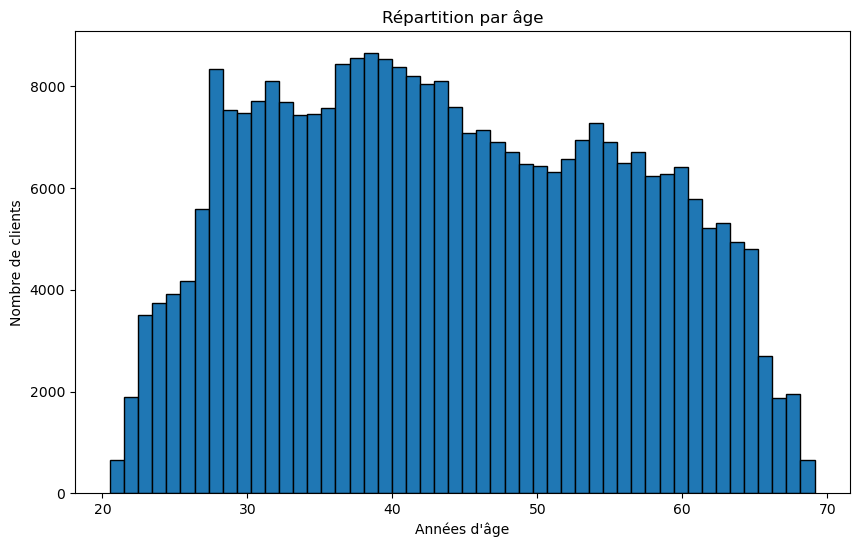

In [12]:
application_train['YEARS_BIRTH'] = application_train['DAYS_BIRTH'] / 365

plt.figure(figsize=(10, 6))
plt.hist(application_train['YEARS_BIRTH'], bins=50, edgecolor='k')
plt.title('Répartition par âge')
plt.xlabel('Années d\'âge')
plt.ylabel('Nombre de clients')
plt.show()

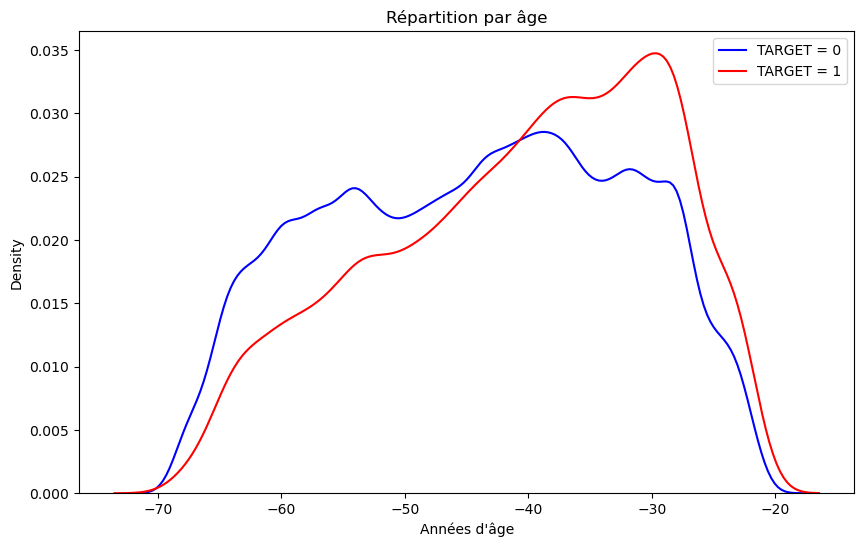

In [215]:
plt.figure(figsize=(10, 6))

sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'YEARS_BIRTH'], label='TARGET = 0', color='blue')

sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'YEARS_BIRTH'], label='TARGET = 1', color='red')

plt.title('Répartition par âge')
plt.xlabel('Années d\'âge')
plt.ylabel('Density')
plt.legend()
plt.show()

""" Comme on peut le constater, la part des non-retours est plus élevée chez les jeunes et diminue avec l’âge. Ce n’est pas une raison pour refuser complètement un prêt aux jeunes : une telle « recommandation » ne fera qu’entraîner une perte de revenus et de marché pour la banque. C'est une raison pour réfléchir à une gestion plus prudente, à une évaluation """

In [ ]:
"""
Analysons les données avec la corrélation la plus élevée
EXT_SOURCE_3               0.247680
EXT_SOURCE_1               0.217846
EXT_SOURCE_2               0.213965
"""

Text(0.5, 1.0, 'EXT_SOURCE Correlation Heatmap')

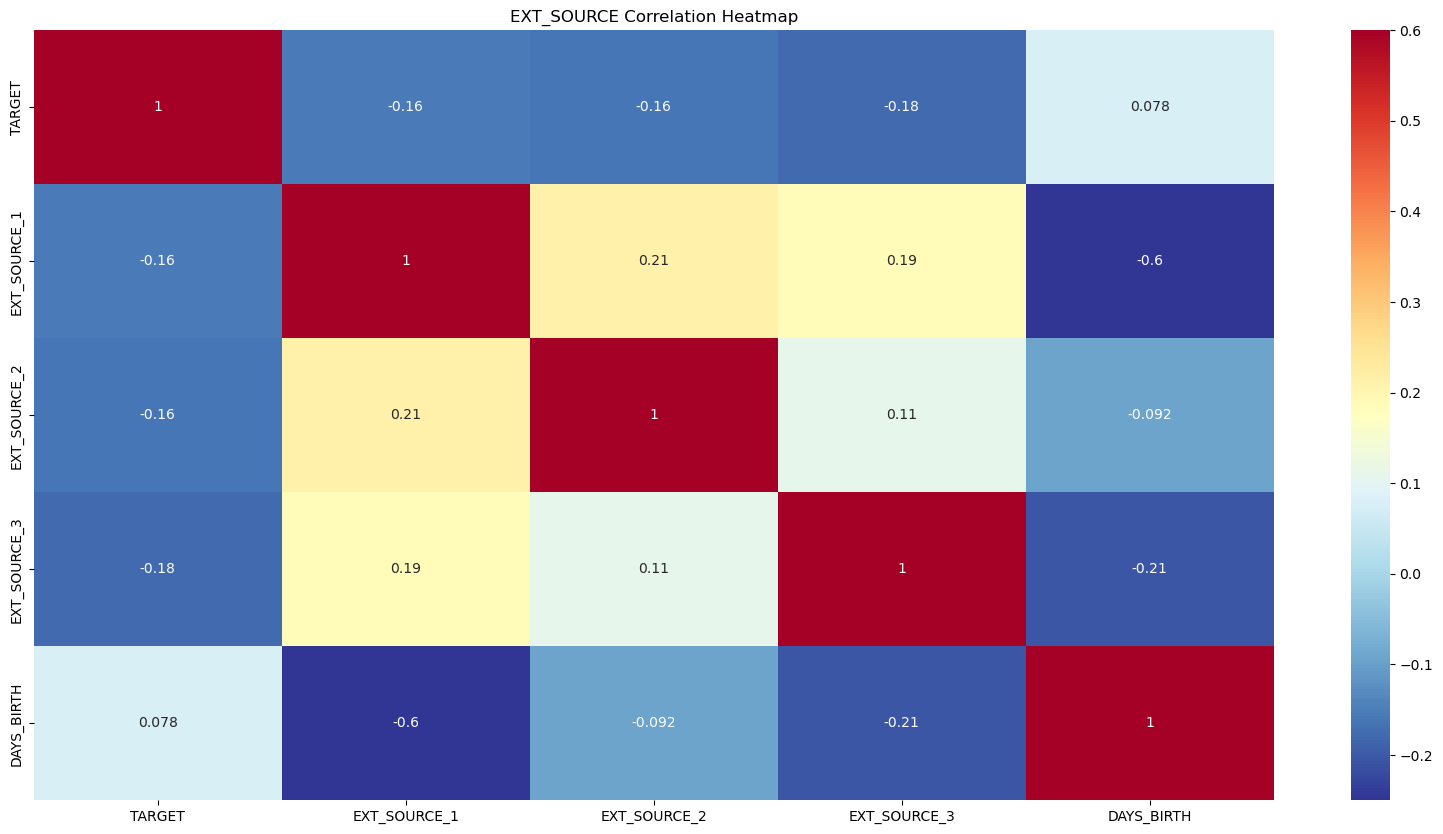

In [166]:
#Heatmap of correlations
plt.figure(figsize = (20,10))
sns.heatmap(application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('EXT_SOURCE Correlation Heatmap')


Ces sources extérieures sont corrélées négativement avec la Target (Attention, négativement mais avec de très faibles coefficients). Malgré tout, on peut penser que si la valeur augmente, le client est plus susceptible de pouvoir rembourser le crédit. Notons que 'DAYS_BIRTH' est corrélée avec 'EXT_SOURCE_1', peut-être l'un des facteurs de ce score est l'âge du client.

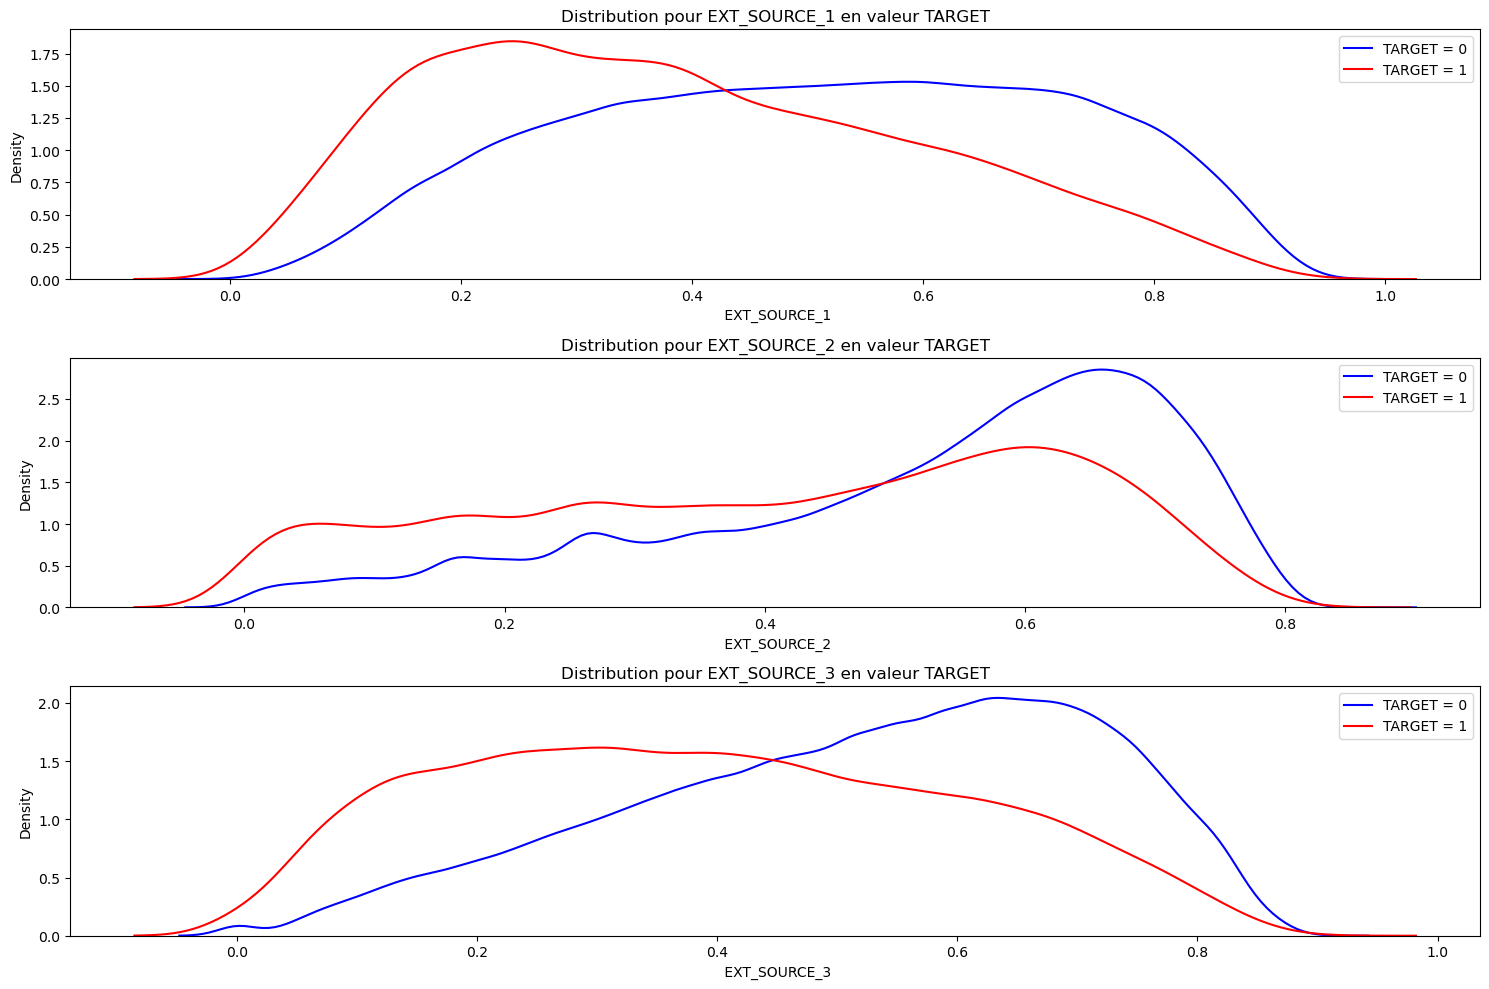

In [187]:
columns_to_plot = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

plt.figure(figsize=(15, 10))
for idx, col in enumerate(columns_to_plot, 1):
    plt.subplot(3, 1, idx)
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, col], label='TARGET = 0', color='blue')
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, col], label='TARGET = 1', color='red')
    plt.title(f'Distribution pour {col} en valeur TARGET')
    plt.xlabel(f' {col}')
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()


La situation est similaire à la répartition par âge : à mesure que l'indicateur augmente, la probabilité de rembourser le prêt augmente. La troisième source est la plus puissante à cet égard. Même si, en termes absolus, la corrélation avec la variable cible se situe toujours dans la catégorie « très faible », les sources de données externes et l'âge auront la plus haute importance dans la construction du modèle.

In [13]:
#Plot distribution of one feature
def plot_distribution(feature, title):
    plt.figure(figsize=(20,6))

    t0 = application_train.loc[application_train['TARGET'] == 0]
    t1 = application_train.loc[application_train['TARGET'] == 1]

    
    sns.kdeplot(t0[feature].dropna(), color='blue', label="TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color='red', label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()
  

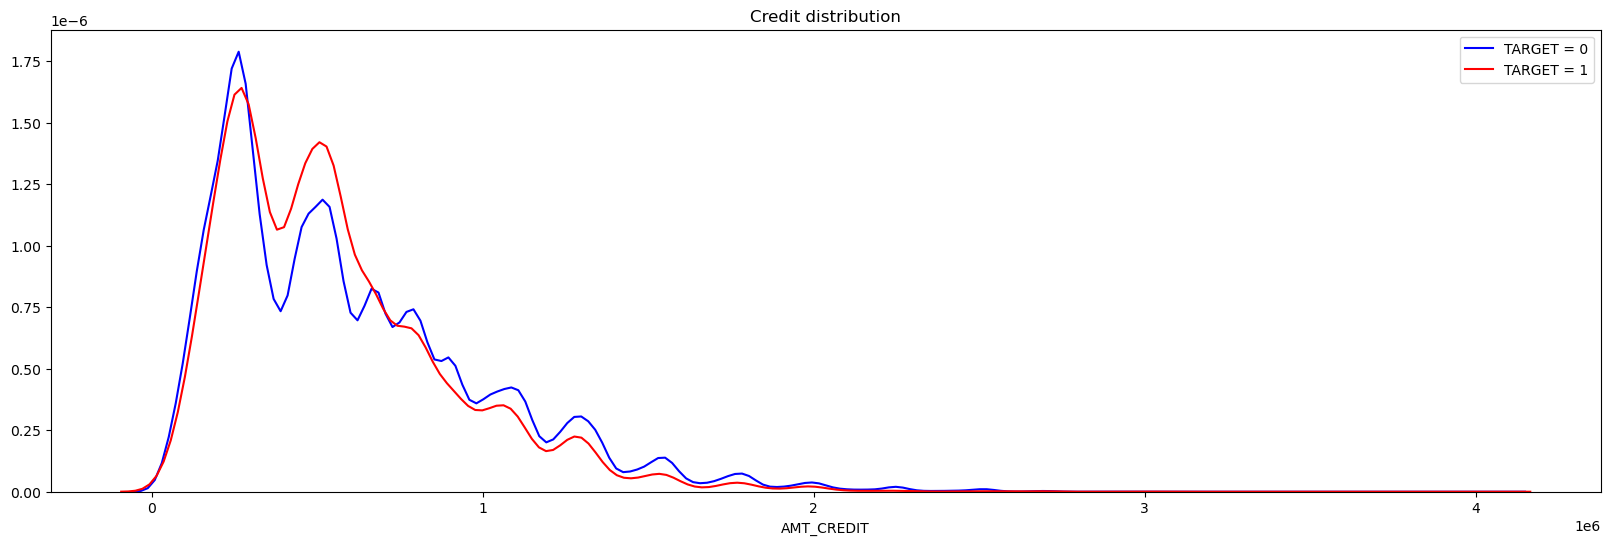

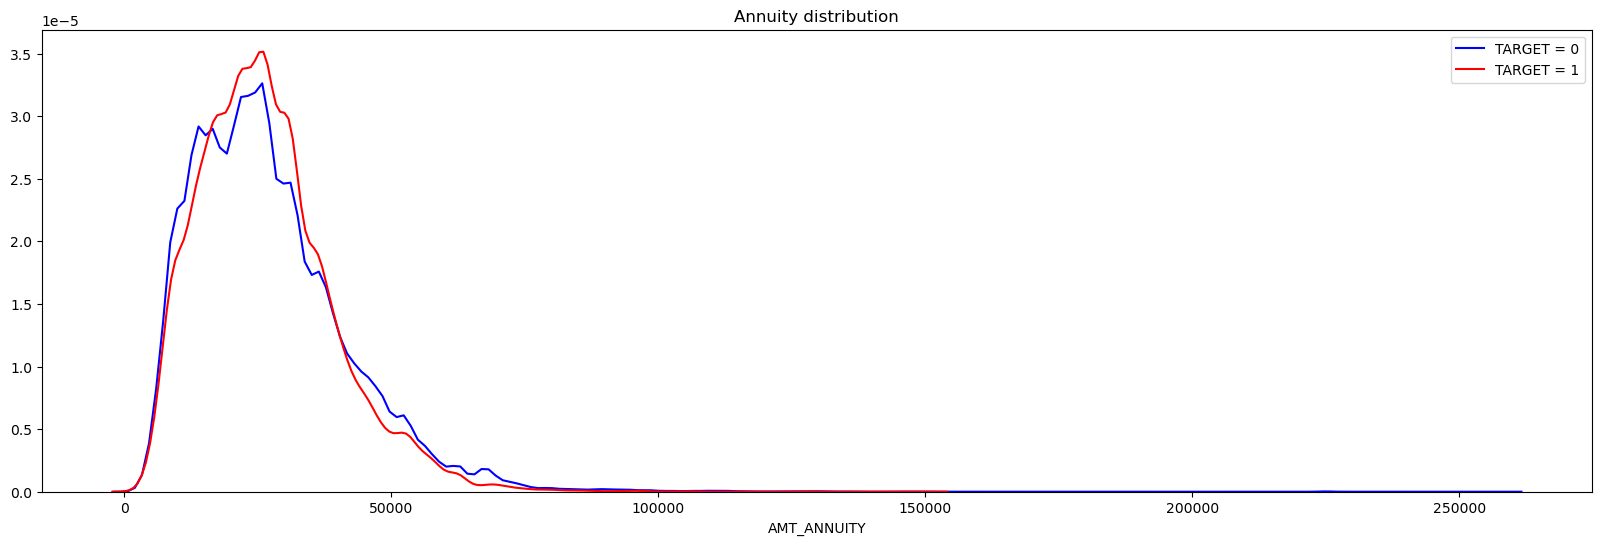

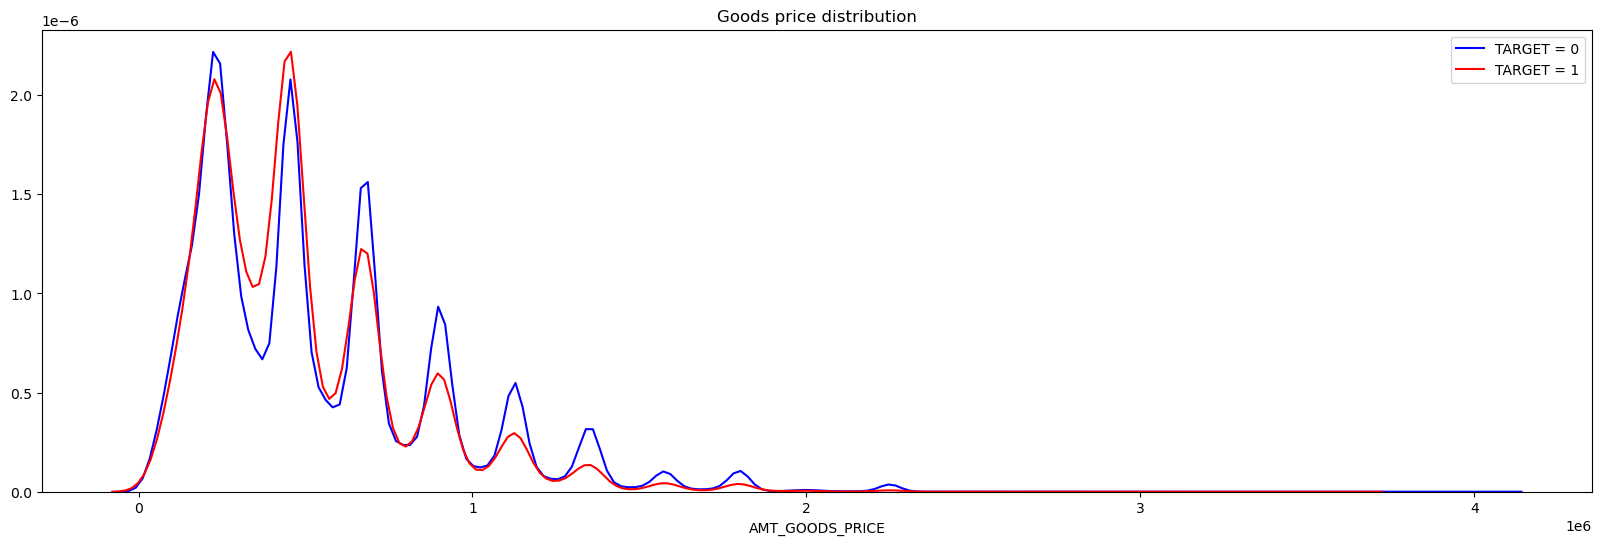

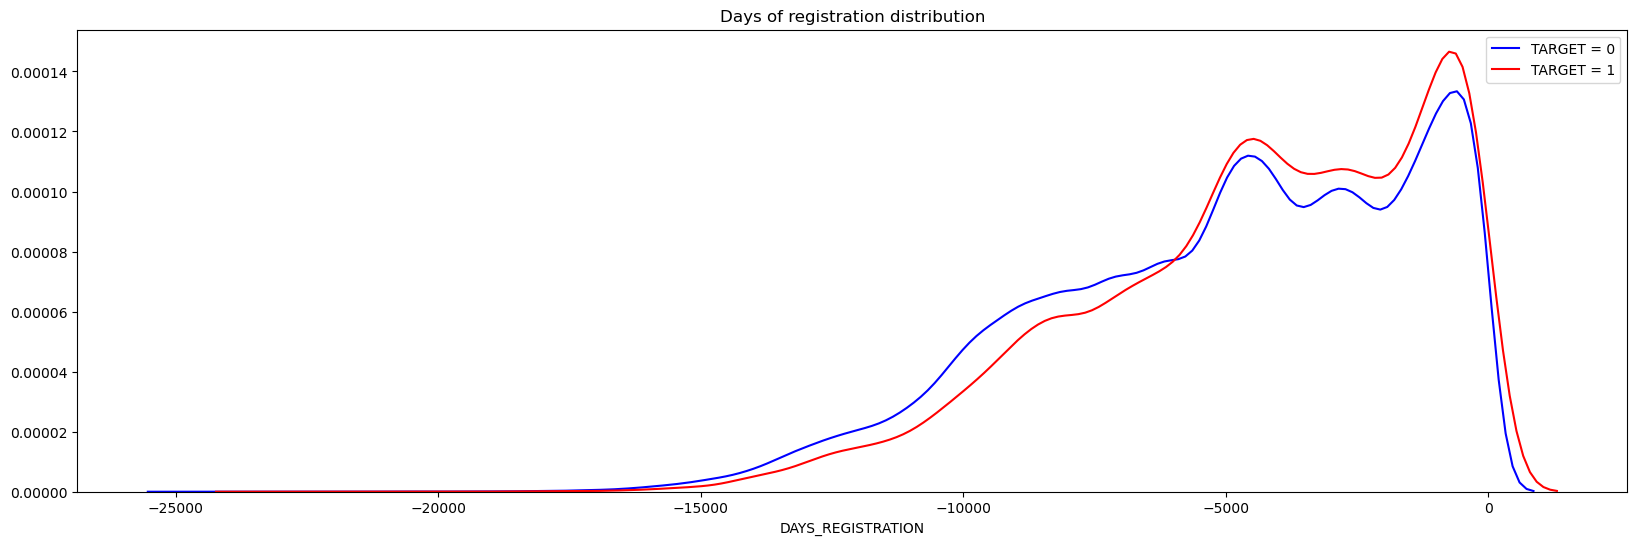

In [189]:
plot_distribution('AMT_CREDIT', "Credit distribution")
print("                                   ")
plot_distribution('AMT_ANNUITY', "Annuity distribution")
print("                                  ")
plot_distribution('AMT_GOODS_PRICE', "Goods price distribution")
print("                                  ")
plot_distribution('DAYS_REGISTRATION', "Days of registration distribution")
print("                                   ")

In [14]:
def analyze_variable_target_relation(df, variable_col, target_col='TARGET'):

    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=variable_col, hue=target_col)
    plt.title(f'Distribution pour {variable_col} relativement {target_col}')
    plt.xlabel(variable_col)
    plt.ylabel('Nombre')
    plt.xticks(rotation=45)
    plt.show()
    
    print(f"Répartition en pourcentage  {target_col}  pour  {variable_col}:\n")
    variable_target_pct = df.groupby(variable_col)[target_col].value_counts(normalize=True).unstack() * 100
    
    return variable_target_pct



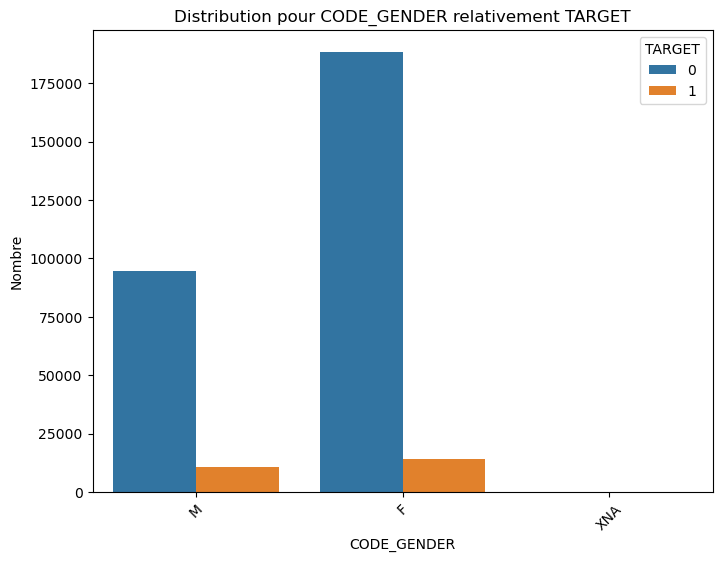

Répartition en pourcentage  TARGET  pour  CODE_GENDER:



TARGET                0          1
CODE_GENDER                       
F             93.000672   6.999328
M             89.858080  10.141920
XNA          100.000000        NaN

In [197]:
analyze_variable_target_relation(app_train, variable_col='CODE_GENDER', target_col='TARGET')

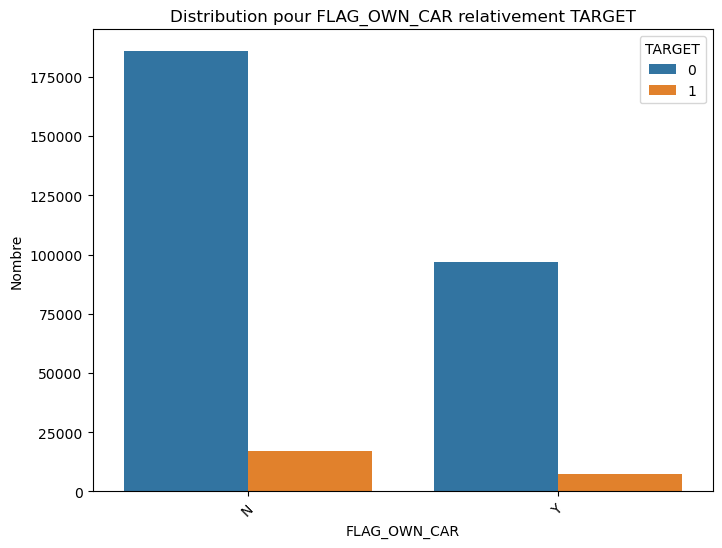

Répartition en pourcentage  TARGET  pour  FLAG_OWN_CAR:



TARGET                0         1
FLAG_OWN_CAR                     
N             91.499773  8.500227
Y             92.756270  7.243730

In [198]:
analyze_variable_target_relation(app_train, variable_col='FLAG_OWN_CAR', target_col='TARGET')

#Il n’y a pas beaucoup de différence dans l’état de remboursement du prêt pour le client. On peut en conclure que cette fonction n'est pas très utile.

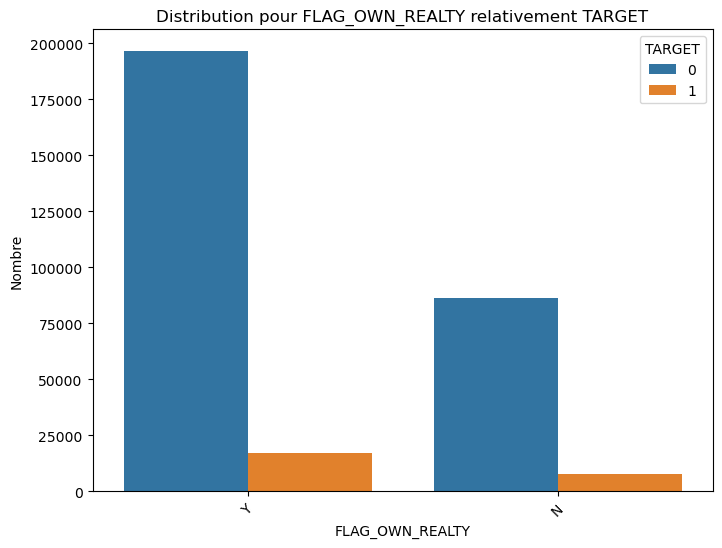

Répartition en pourcentage  TARGET  pour  FLAG_OWN_REALTY:



TARGET                   0         1
FLAG_OWN_REALTY                     
N                91.675071  8.324929
Y                92.038423  7.961577

In [199]:
analyze_variable_target_relation(app_train, variable_col='FLAG_OWN_REALTY', target_col='TARGET')

Il n’y a pas beaucoup de différence dans l’état de remboursement du prêt pour le client. On peut en conclure que cette fonction n'est pas très utile.

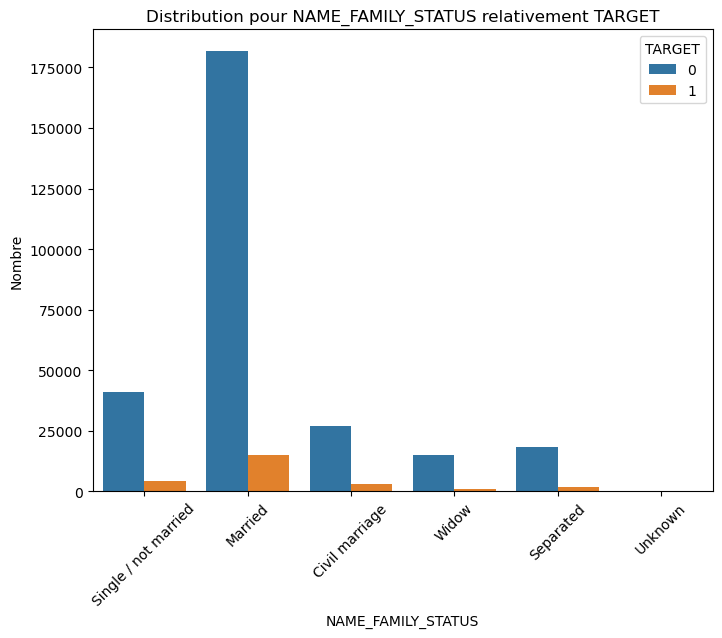

Répartition en pourcentage  TARGET  pour  NAME_FAMILY_STATUS:



TARGET                         0         1
NAME_FAMILY_STATUS                        
Civil marriage         90.055416  9.944584
Married                92.440132  7.559868
Separated              91.805766  8.194234
Single / not married   90.192325  9.807675
Unknown               100.000000       NaN
Widow                  94.175783  5.824217

In [200]:
analyze_variable_target_relation(app_train, variable_col='NAME_FAMILY_STATUS', target_col='TARGET')

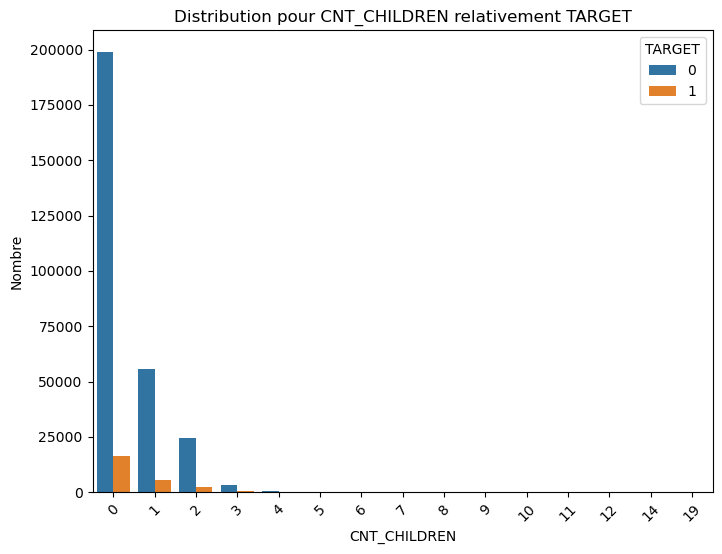

Répartition en pourcentage  TARGET  pour  CNT_CHILDREN:



TARGET                 0           1
CNT_CHILDREN                        
0              92.288191    7.711809
1              91.076425    8.923575
2              91.278179    8.721821
3              90.368577    9.631423
4              87.179487   12.820513
5              91.666667    8.333333
6              71.428571   28.571429
7             100.000000         NaN
8             100.000000         NaN
9                    NaN  100.000000
10            100.000000         NaN
11                   NaN  100.000000
12            100.000000         NaN
14            100.000000         NaN
19            100.000000         NaN

In [201]:
analyze_variable_target_relation(app_train, variable_col='CNT_CHILDREN', target_col='TARGET')

In [202]:
app_train.CNT_CHILDREN.value_counts()

CNT_CHILDREN
0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: count, dtype: int64

Il n’y a pas beaucoup de différence dans l’état de remboursement du prêt pour le client. On peut en conclure que cette fonction n'est pas très utile.

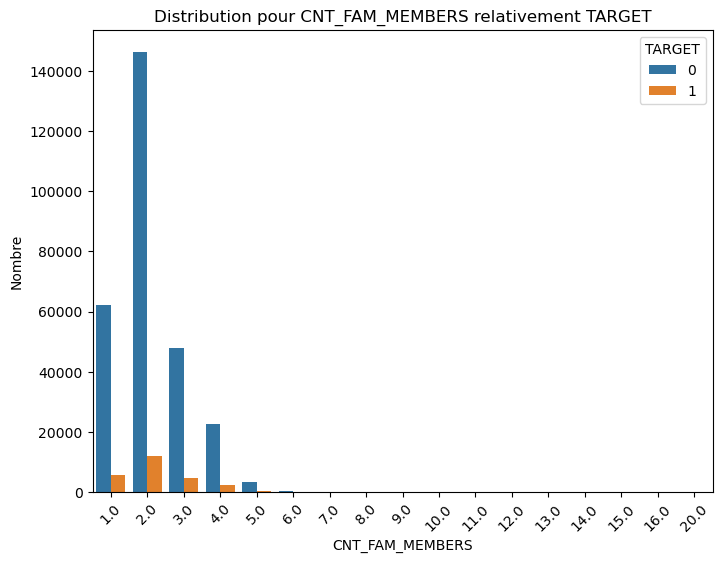

Répartition en pourcentage  TARGET  pour  CNT_FAM_MEMBERS:



TARGET                    0           1
CNT_FAM_MEMBERS                        
1.0               91.635592    8.364408
2.0               92.416502    7.583498
3.0               91.239710    8.760290
4.0               91.351176    8.648824
5.0               90.598045    9.401955
6.0               86.519608   13.480392
7.0               92.592593    7.407407
8.0               70.000000   30.000000
9.0              100.000000         NaN
10.0              66.666667   33.333333
11.0                    NaN  100.000000
12.0             100.000000         NaN
13.0                    NaN  100.000000
14.0             100.000000         NaN
15.0             100.000000         NaN
16.0             100.000000         NaN
20.0             100.000000         NaN

In [203]:
analyze_variable_target_relation(app_train, variable_col='CNT_FAM_MEMBERS', target_col='TARGET')

In [204]:
app_train.CNT_FAM_MEMBERS.value_counts()

CNT_FAM_MEMBERS
2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: count, dtype: int64

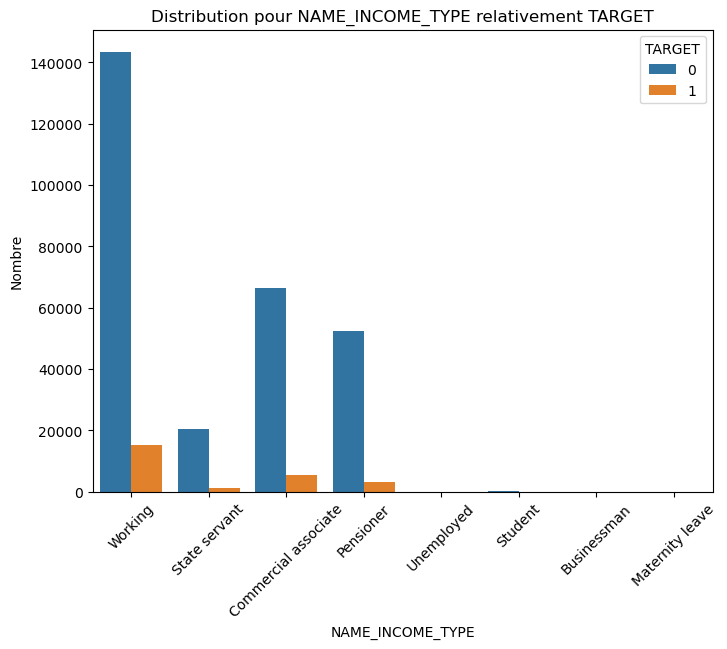

Répartition en pourcentage  TARGET  pour  NAME_INCOME_TYPE:



TARGET                         0          1
NAME_INCOME_TYPE                           
Businessman           100.000000        NaN
Commercial associate   92.515743   7.484257
Maternity leave        60.000000  40.000000
Pensioner              94.613634   5.386366
State servant          94.245035   5.754965
Student               100.000000        NaN
Unemployed             63.636364  36.363636
Working                90.411528   9.588472

In [205]:
analyze_variable_target_relation(app_train, variable_col='NAME_INCOME_TYPE', target_col='TARGET')

In [206]:
app_train.NAME_INCOME_TYPE.value_counts()

NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

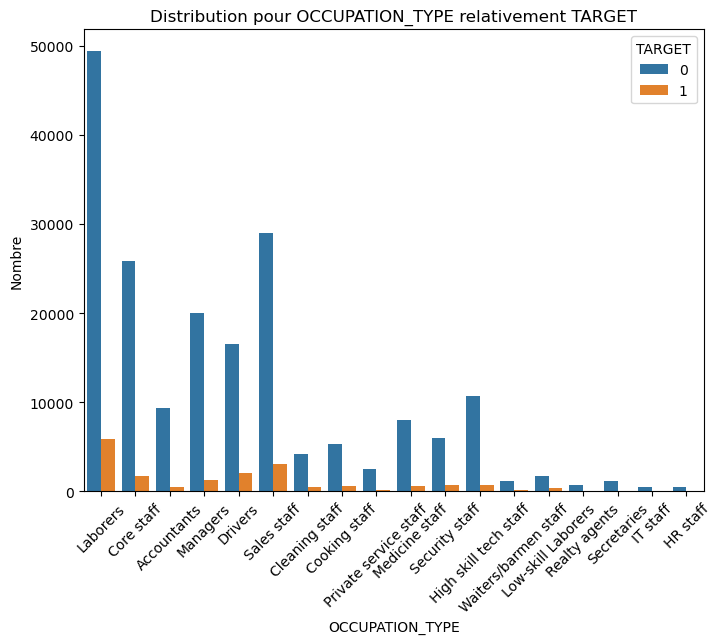

Répartition en pourcentage  TARGET  pour  OCCUPATION_TYPE:



TARGET                         0          1
OCCUPATION_TYPE                            
Accountants            95.169673   4.830327
Cleaning staff         90.393295   9.606705
Cooking staff          89.556004  10.443996
Core staff             93.696046   6.303954
Drivers                88.673870  11.326130
HR staff               93.605684   6.394316
High skill tech staff  93.840070   6.159930
IT staff               93.536122   6.463878
Laborers               89.421230  10.578770
Low-skill Laborers     82.847587  17.152413
Managers               93.785972   6.214028
Medicine staff         93.299754   6.700246
Private service staff  93.401207   6.598793
Realty agents          92.143808   7.856192
Sales staff            90.368201   9.631799
Secretaries            92.950192   7.049808
Security staff         89.257551  10.742449
Waiters/barmen staff   88.724036  11.275964

In [207]:
analyze_variable_target_relation(app_train, variable_col='OCCUPATION_TYPE', target_col='TARGET')

In [208]:
app_train.OCCUPATION_TYPE.value_counts()

OCCUPATION_TYPE
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

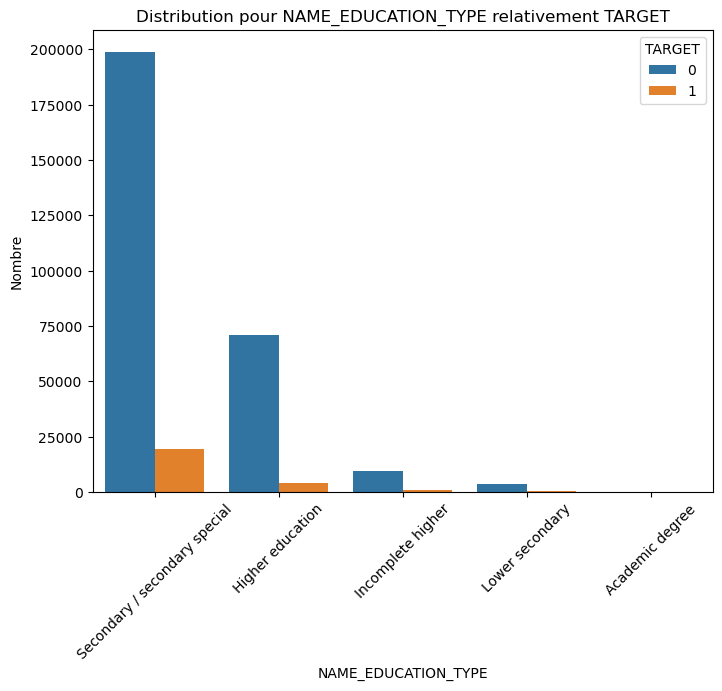

Répartition en pourcentage  TARGET  pour  NAME_EDUCATION_TYPE:



TARGET                                 0          1
NAME_EDUCATION_TYPE                                
Academic degree                98.170732   1.829268
Higher education               94.644885   5.355115
Incomplete higher              91.515034   8.484966
Lower secondary                89.072327  10.927673
Secondary / secondary special  91.060071   8.939929

In [209]:
analyze_variable_target_relation(app_train, variable_col='NAME_EDUCATION_TYPE', target_col='TARGET')

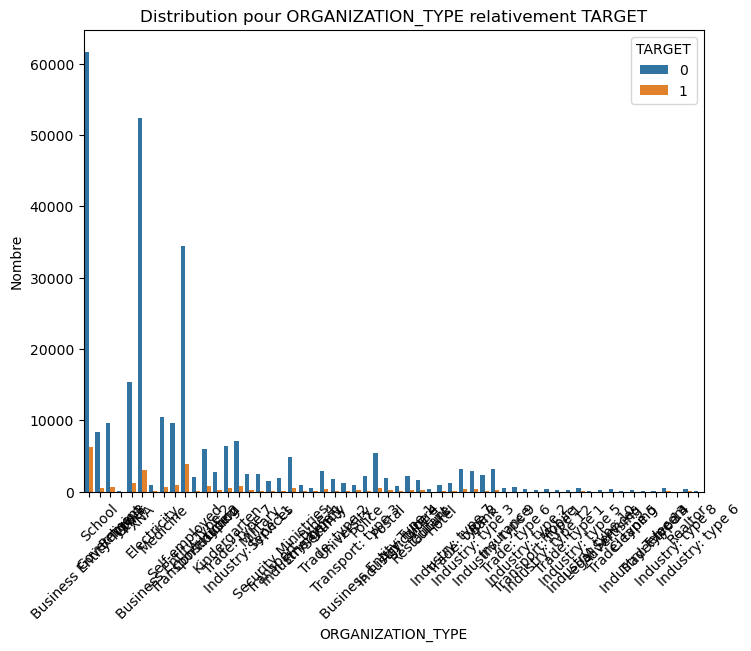

Répartition en pourcentage  TARGET  pour  ORGANIZATION_TYPE:



TARGET                          0          1
ORGANIZATION_TYPE                           
Advertising             91.841492   8.158508
Agriculture             89.527302  10.472698
Bank                    94.814519   5.185481
Business Entity Type 1  91.861631   8.138369
Business Entity Type 2  91.471619   8.528381
Business Entity Type 3  90.700377   9.299623
Cleaning                88.846154  11.153846
Construction            88.320190  11.679810
Culture                 94.459103   5.540897
Electricity             93.368421   6.631579
Emergency               92.857143   7.142857
Government              93.021915   6.978085
Hotel                   93.581781   6.418219
Housing                 92.055443   7.944557
Industry: type 1        88.931665  11.068335
Industry: type 10       93.577982   6.422018
Industry: type 11       91.346154   8.653846
Industry: type 12       96.205962   3.794038
Industry: type 13       86.567164  13.432836
Industry: type 2        92.794760   7.205240
Industry: type 3        89.383771  10.616229
Industry: type 4        89.851767  10.148233
Industry: type 5        93.155259   6.844741
Industry: type 6        92.857143   7.142857
Industry: type 7        91.966335   8.033665
Industry: type 8        87.500000  12.500000
Industry: type 9        93.319477   6.680523
Insurance               94.304858   5.695142
Kindergarten            92.965116   7.034884
Legal Services          92.131148   7.868852
Medicine                93.415528   6.584472
Military                94.874715   5.125285
Mobile                  90.851735   9.148265
Other                   92.357490   7.642510
Police                  95.002136   4.997864
Postal                  91.562355   8.437645
Realtor                 89.393939  10.606061
Religion                94.117647   5.882353
Restaurant              88.293760  11.706240
School                  94.085236   5.914764
Security                90.021558   9.978442
Security Ministries     95.136778   4.863222
Self-employed           89.826096  10.173904
Services                93.396825   6.603175
Telecom                 92.374350   7.625650
Trade: type 1           91.091954   8.908046
Trade: type 2           93.000000   7.000000
Trade: type 3           89.662085  10.337915
Trade: type 4           96.875000   3.125000
Trade: type 5           93.877551   6.122449
Trade: type 6           95.404120   4.595880
Trade: type 7           90.550377   9.449623
Transport: type 1       95.522388   4.477612
Transport: type 2       92.196007   7.803993
Transport: type 3       84.245998  15.754002
Transport: type 4       90.718785   9.281215
University              95.101733   4.898267
XNA                     94.600354   5.399646

In [210]:
analyze_variable_target_relation(app_train, variable_col='ORGANIZATION_TYPE', target_col='TARGET')

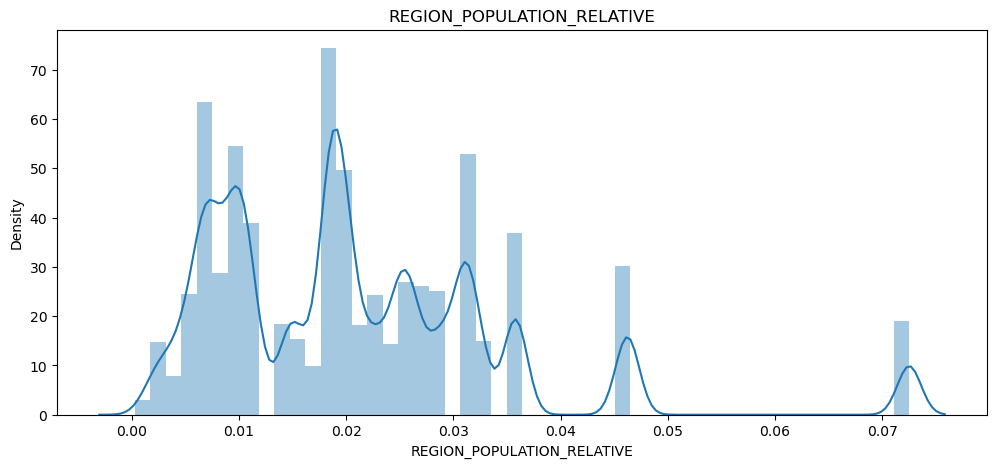

In [211]:
plt.figure(figsize=(12,5))
plt.title("REGION_POPULATION_RELATIVE")
ax = sns.distplot(application_train["REGION_POPULATION_RELATIVE"])

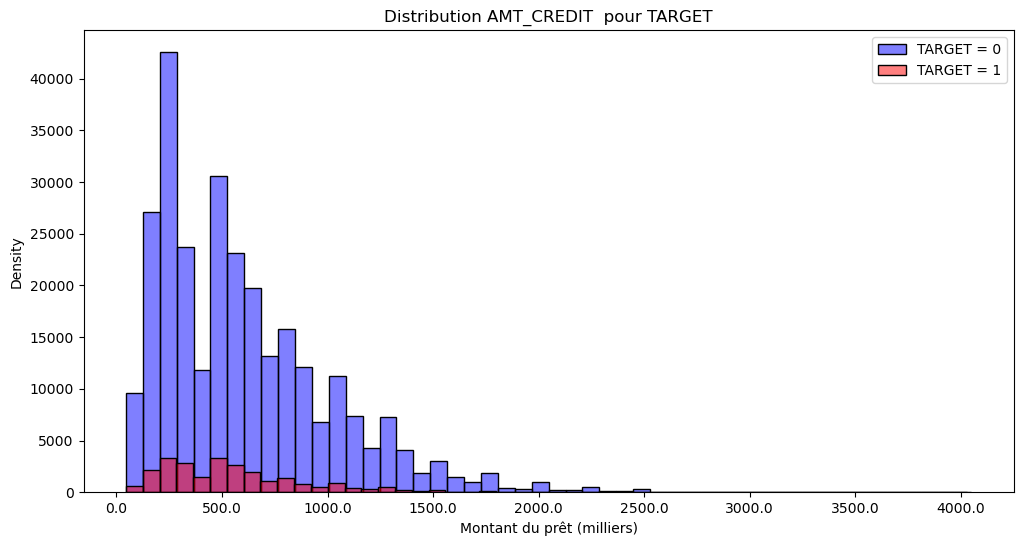

In [212]:
def plot_credit_distribution_target(df, credit_col='AMT_CREDIT', target_col='TARGET'):
   
    plt.figure(figsize=(12, 6))

    sns.histplot(df[df[target_col] == 0][credit_col]/1000, bins=50, kde=False, label='TARGET = 0', color='blue', alpha=0.5)
    sns.histplot(df[df[target_col] == 1][credit_col]/1000, bins=50, kde=False, label='TARGET = 1', color='red', alpha=0.5)
    plt.title(f'Distribution {credit_col}  pour {target_col}')
    plt.xlabel('Montant du prêt (milliers)')
    plt.ylabel('Density')
    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    plt.legend()
    plt.show()

plot_credit_distribution_target(app_train, credit_col='AMT_CREDIT', target_col='TARGET')


In [15]:
# Créer un nouveau bloc de données pour les fonctions polynomiales
poly_features = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

In [16]:
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])
imputer = SimpleImputer(strategy = 'median')
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)                               
poly_transformer = PolynomialFeatures(degree = 3)

In [17]:
poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [18]:
poly_transformer.get_feature_names_out(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]


array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [19]:
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['TARGET'] = poly_target
poly_corrs = poly_features.corr()['TARGET'].sort_values()
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [20]:
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 156)
Testing data with polynomial features shape:   (48744, 156)


In [21]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['INCOME_CREDIT_PERCENT'] = app_train_domain['AMT_INCOME_TOTAL'] / app_train_domain['AMT_CREDIT']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
app_train_domain['INCOME_PER_PERSON'] = app_train_domain['AMT_INCOME_TOTAL'] / app_train_domain['CNT_FAM_MEMBERS']

app_test_domain['INCOME_CREDIT_PERCENT'] = app_test_domain['AMT_INCOME_TOTAL'] / app_test_domain['AMT_CREDIT']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']
app_test_domain['INCOME_PER_PERSON'] = app_test_domain['AMT_INCOME_TOTAL'] / app_test_domain['CNT_FAM_MEMBERS']


In [22]:
print('Training data with domain features shape: ', app_train_domain.shape)
print('Testing data with domain features shape:  ', app_test_domain.shape)

Training data with domain features shape:  (307511, 127)
Testing data with domain features shape:   (48744, 126)


In [23]:
app_train_poly_encod = pd.get_dummies(app_train_poly)
app_test_poly_encod = pd.get_dummies(app_train_poly)

In [24]:
print('Training Features shape: ', app_train_poly_encod.shape)

Training Features shape:  (307511, 280)


In [25]:
print('Testing Features shape: ', app_test_poly_encod.shape)

Testing Features shape:  (307511, 280)


In [43]:
app_test_domain.to_csv("test_feature_engineering.csv", index=False)


In [26]:
app_train_encod = pd.get_dummies(app_train_domain)
app_test_encod = pd.get_dummies(app_test_domain)

In [27]:
print('Training Features shape: ', app_train_encod.shape)

Training Features shape:  (307511, 251)


In [28]:
print('Testing Features shape: ', app_test_encod.shape)

Testing Features shape:  (48744, 247)


Étant donné que le nombre d’options dans les colonnes d’échantillon n’est pas égal, le nombre de colonnes ne correspond plus. L'alignement est requis : vous devez supprimer les colonnes de l'échantillon d'apprentissage qui ne figurent pas dans l'échantillon de test.

In [29]:
print(app_train_encod.columns)


Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=251)


In [30]:
train_labels = application_train['TARGET']

In [31]:
app_train_encod, app_test_encod = app_train_encod.align(app_test_encod, join='inner', axis=1)


In [32]:
app_train_encod.shape

(307511, 247)

In [33]:
app_test_encod.shape

(48744, 247)

In [34]:
df_scores = pd.DataFrame(columns=['modele', 'Mean_ROC_AUC', 'G-Mean', 'time'])

def score(model, X_val, y_val, name, time):
    y_pred = model.predict(X_val)
    mean_roc_auc = roc_auc_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    gmean = g_mean(y_val, y_pred)
    
    # Stockage des résultats dans un DataFrame
    df_scores.loc[df_scores.shape[0]] = [name, mean_roc_auc, gmean, time]
    df_scores.sort_values(by='Mean_ROC_AUC', ascending=False, inplace=True)
    df_scores.drop_duplicates(subset=['modele'], keep='last', inplace=True)
    df_scores.reset_index(drop=True, inplace=True)
    
    # Confusion Matrix
    plot_confusion_matrix(cm, name)
    return df_scores

def plot_confusion_matrix(confusion_matrix, modele_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title(f'Confusion Matrix for {modele_name}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

def g_mean(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    return (sensitivity * specificity) ** 0.5


In [38]:
#Remplir les valeurs manquantes dans les données
imputer = SimpleImputer(strategy='median')
imputer.fit(app_train_encod)

# Transformation des ensembles de données et reconversion en DataFrame
train_imputed = pd.DataFrame(imputer.transform(app_train_encod), columns=app_train_encod.columns)
test_imputed = pd.DataFrame(imputer.transform(app_test_encod), columns=app_test_encod.columns)

# Appliquer un scaler aux données d'entraînement
#from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_imputed)

train_scaled = pd.DataFrame(scaler.transform(train_imputed), columns=train_imputed.columns)
test_scaled = pd.DataFrame(scaler.transform(test_imputed), columns=test_imputed.columns)

X_train = train_scaled
y_train = train_labels
X_test = test_scaled

In [39]:
X_train.shape

(307511, 247)

In [40]:
X_test.shape

(48744, 247)

In [41]:
id_mapping = {scaled_id: original_id for scaled_id, original_id in zip(X_test['SK_ID_CURR'].tolist(), test_id)}

X_test['SK_ID_CURR'] = X_test['SK_ID_CURR'].map(id_mapping)
X_test['SK_ID_CURR']

0        100001
1        100005
2        100013
3        100028
4        100038
          ...  
48739    456221
48740    456222
48741    456223
48742    456224
48743    456250
Name: SK_ID_CURR, Length: 48744, dtype: int64

In [284]:
# Create experiment
experiment_name = 'credit_scoring'
mlflow.set_experiment(experiment_name)
mlflow.end_run()

2023/10/25 22:28:50 INFO mlflow.tracking.fluent: Experiment with name 'credit_scoring' does not exist. Creating a new experiment.


In [285]:
# Fonction pour enregistrer le modèle dans mlflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, auc_score=None, f1_score=None, acc_score=None,
               train_class_0=None, train_class_1=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

In [ ]:
test_scaled=

# Nous avons des données déséquilibrées : l'échantillon d'apprentissage contient une forte inadéquation entre les classes à prédire.

In [289]:
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
"""
1)LogisticRegression
2)RandomForestClassifier
Nous utiliserons le modèle de pénalité en utilisant le paramètre `class_weight`.
Ce qui permet d'attribuer à chaque classe un poids inversement proportionnel à sa fréquence.

3)BalancedRandomForestClassifier
Une variante de RandomForest qui sous-échantillonne à partir d'une classe plus petite
pour chaque arbre de la forêt.Un modèle qui peut équilibrer automatiquement les cours pendant l'entraînement.
"""

In [296]:
# roc curve
def compute_roc_curve(y_val, y_pred_proba, model_name="Model", disp_best_th=False):
    # metrics
    fpr, tpr, thresholds = roc_curve(y_val,  y_pred_proba)
    auc = roc_auc_score(y_val, y_pred_proba)
  
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    #ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    # Return AUC score
    return auc

In [297]:
# confusion matrix
def display_confusion_matrix(y_val, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [290]:
#Création de pipelines pour différents modèles
pipelines = {
    "log_reg": Pipeline([("classifier", LogisticRegression(class_weight='balanced', max_iter=1000))]),
    "random_forest": Pipeline([("classifier", RandomForestClassifier(class_weight='balanced'))]),
    "balanced_rf": Pipeline([("classifier", BalancedRandomForestClassifier())])
}

# Hyperparamètres pour l'optimisation
params = {
    "log_reg": {"classifier__C": [0.001, 0.01]},
    "random_forest": {"classifier__n_estimators": [50, 100], "classifier__max_depth": [None, 10, 20]},
    "balanced_rf": {"classifier__n_estimators": [50, 100]}
}

# Trouver les meilleurs paramètres
best_models = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, params[name], cv=5, scoring="roc_auc")
    grid_search.fit(X_train_subset, y_train_subset)
    best_models[name] = grid_search.best_estimator_

In [298]:
COST_FN = 10  # Le coût d’un résultat faussement négatif
COST_FP = 1   # Le coût d’un résultat faussement positif

def custom_loss(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return COST_FN * cm[1][0] + COST_FP * cm[0][1]


In [299]:
#fonctions de perte pour sélectionner la valeur seuil optimale
def find_best_threshold(model, X, y):
    probas = model.predict_proba(X)[:, 1]
    thresholds = np.linspace(0, 1, 100)
    losses = []
    
    for t in thresholds:
        y_pred = (probas > t).astype(int)
        losses.append(custom_loss(y, y_pred))
    
    best_threshold = thresholds[np.argmin(losses)]
    return best_threshold


## Un modèle de référence pour évaluer le pouvoir prédictif du modèle choisi (dummyClassifier)

In [300]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_subset, y_train_subset)
dummy_predictions = dummy.predict(X_val)
dummy_predictions_prob = dummy.predict_proba(X_val)[:, 1]
best_models["dummy"] = dummy



In [311]:
best_models["dummy"] = dummy


In [313]:
best_models

{'log_reg': Pipeline(steps=[('classifier',
                  LogisticRegression(C=0.01, class_weight='balanced',
                                     max_iter=1000))]),
 'random_forest': Pipeline(steps=[('classifier',
                  RandomForestClassifier(class_weight='balanced',
                                         max_depth=10))]),
 'balanced_rf': Pipeline(steps=[('classifier', BalancedRandomForestClassifier())]),
 'dummy': DummyClassifier(strategy='most_frequent')}

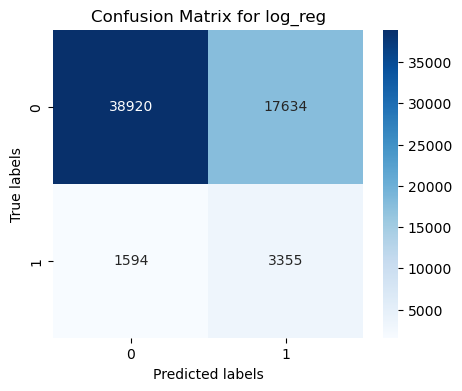

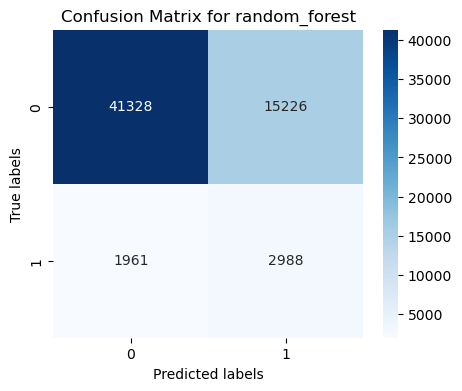

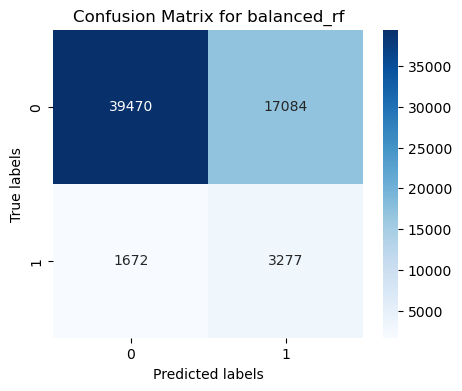

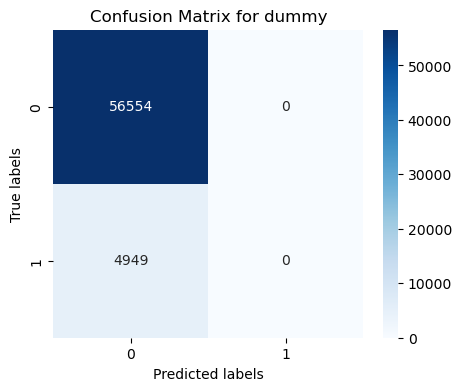

In [324]:
for name, model in best_models.items():
    start_time = time.time()

    # Trouver le seuil optimal pour le modèle
    threshold = find_best_threshold(model, X_val, y_val)

    # Utiliser un seuil pour prédire les étiquettes sur les données de validation
    y_pred_proba = (model.predict_proba(X_val)[:, 1] > threshold).astype(int)
    y_pred = model.predict(X_val)

    # métriques pour les prédictions
    mean_roc_auc = roc_auc_score(y_val, y_pred_proba)
    cm = confusion_matrix(y_val, y_pred)
    gmean = g_mean(y_val, y_pred)

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Ajout de résultats à df_scores
    df_scores.loc[df_scores.shape[0]] = [name, mean_roc_auc, gmean, elapsed_time]
    plot_confusion_matrix(cm, name)

    

In [326]:
df_scores['Accuracy'] = df_scores.apply(lambda row: accuracy_score(y_val, best_models[row['modele']].predict(X_val)), axis=1)
df_scores['Recall'] = df_scores.apply(lambda row: recall_score(y_val, best_models[row['modele']].predict(X_val)), axis=1)
print(df_scores)


          modele  Mean_ROC_AUC    G-Mean      time  Accuracy    Recall
0        log_reg      0.682935  0.683034  0.766105  0.687365  0.677915
1  random_forest      0.673096  0.664236  3.465762  0.720550  0.603758
2    balanced_rf      0.680222  0.679800  7.790644  0.695039  0.662154
3          dummy      0.500000  0.000000  0.734888  0.919532  0.000000


ROC AUC 0,5 : cela indique que le modèle ne fait pas du tout de distinction entre les deux classes. La valeur 0,5 est un choix aléatoire.

Précision 0,9195 : Cela signifie que 91,95 % de toutes les prédictions étaient correctes. Mais, compte tenu de la faible valeur de ROC AUC, cela indique simplement que l'ensemble de données est déséquilibré et que la plupart des enregistrements appartiennent à la classe « 0 ».

Précision 0,0 : cela signifie que parmi toutes les prédictions pour lesquelles le modèle pense que l'observation appartient à la classe « 1 », aucune n'était correcte.

Complétude (rappel) 0,0 : aucune des observations de classe « 1 » n'a été correctement prédite.

Score F1 0,0 : Il s'agit d'une moyenne harmonique entre l'exactitude et l'exhaustivité. Une valeur de 0 indique une faible efficacité du modèle dans la prédiction de la classe « 1 ».

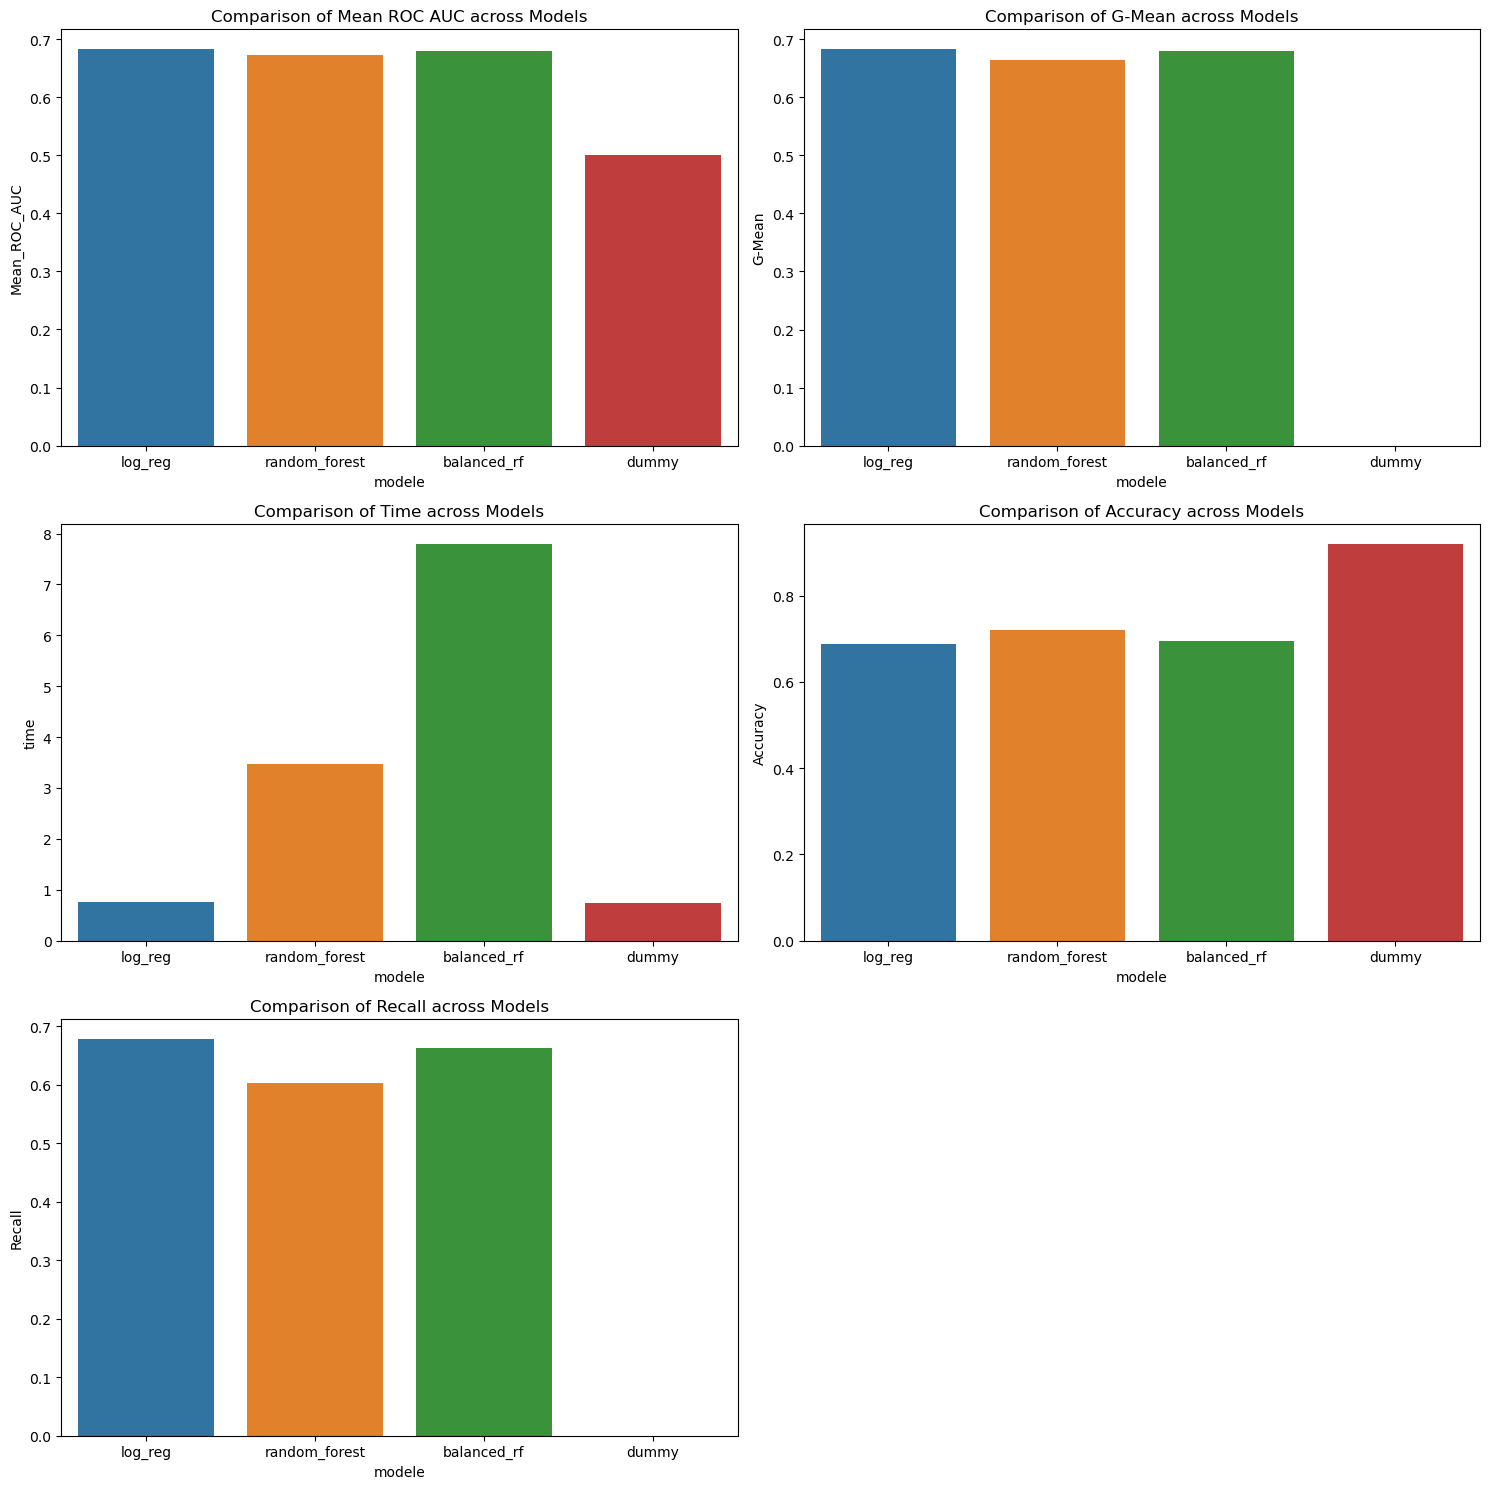

In [327]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Mean_ROC_AUC
sns.barplot(x='modele', y='Mean_ROC_AUC', data=df_scores, ax=axes[0, 0])
axes[0, 0].set_title('Comparison of Mean ROC AUC across Models')

# G-Mean
sns.barplot(x='modele', y='G-Mean', data=df_scores, ax=axes[0, 1])
axes[0, 1].set_title('Comparison of G-Mean across Models')

# Time
sns.barplot(x='modele', y='time', data=df_scores, ax=axes[1, 0])
axes[1, 0].set_title('Comparison of Time across Models')

# Accuracy
sns.barplot(x='modele', y='Accuracy', data=df_scores, ax=axes[1, 1])
axes[1, 1].set_title('Comparison of Accuracy across Models')

# Recall
sns.barplot(x='modele', y='Recall', data=df_scores, ax=axes[2, 0])
axes[2, 0].set_title('Comparison of Recall across Models')

axes[2, 1].axis('off')
plt.tight_layout()
plt.show()


# Ainsi, sur la base de ces mesures, la régression logistique est le meilleur choix.

In [328]:
%%time
# Meilleure sélection de modèle basée sur ROC AUC
best_model_name = df_scores.iloc[0]['modele']
best_model = best_models[best_model_name]

# Prédiction sur l'ensemble de données de test en utilisant le seuil optimal
best_threshold = find_best_threshold(best_model, X_val, y_val)
final_predictions = (best_model.predict_proba(X_test)[:, 1] > best_threshold).astype(int)


CPU times: user 1.26 s, sys: 257 ms, total: 1.51 s
Wall time: 1.07 s


# SHAP

In [374]:
linear_model = best_models["log_reg"].named_steps["classifier"]

# SHAP LinearExplainer
explainer = shap.LinearExplainer(linear_model, X_train)



In [375]:
with open('explainer.pkl', 'wb') as file:
    pickle.dump(explainer, file)

In [334]:
shap_values = explainer.shap_values(X_val)

In [44]:
import shap
shap.initjs()


In [ ]:
shap.force_plot(explainer.expected_value, shap_values[4,:], X_val.iloc[4,:])


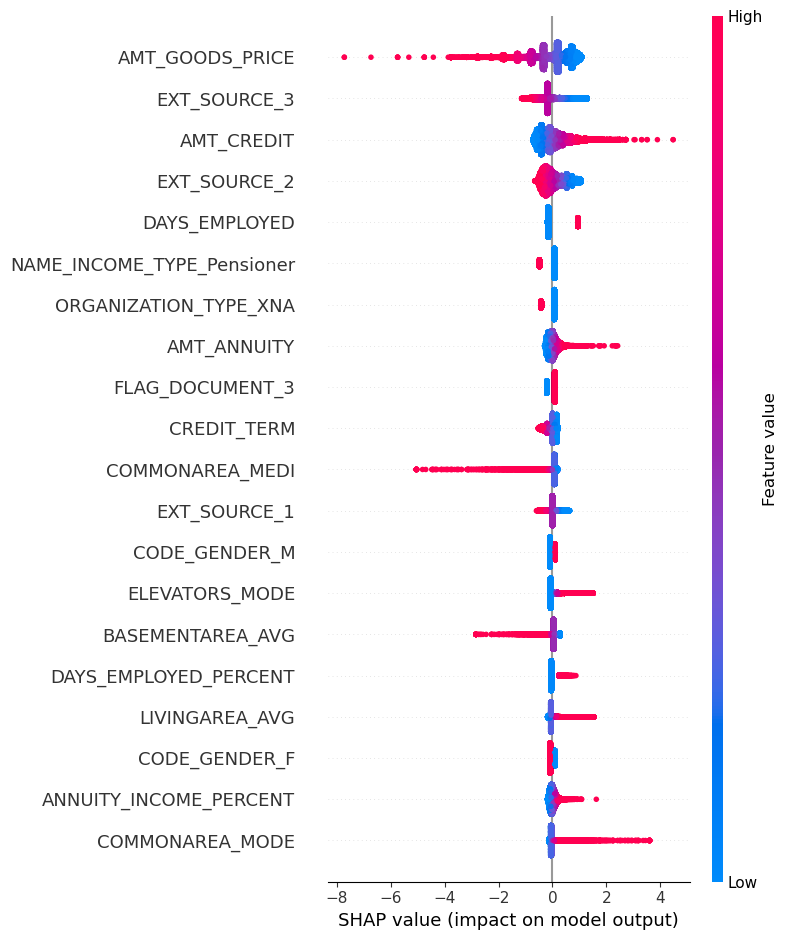

In [340]:
shap.summary_plot(shap_values, X_val)


In [351]:
shap.force_plot(explainer.expected_value, shap_values[0:20,:], X_test.iloc[0:20,:])


In [371]:
classifier = best_model.named_steps["classifier"]
coefficients = classifier.coef_


In [362]:
columns = X_train.columns

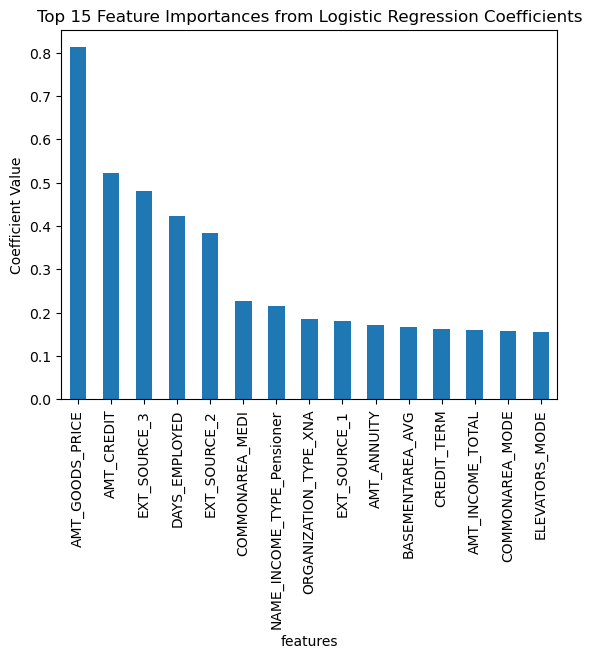

In [378]:
def logistic_regression_top_importances_chart(model, feature_names, top_n=15):
    classifier = model.named_steps["classifier"]
    imp_df = pd.DataFrame({
        'features': feature_names,
        'importances': np.abs(classifier.coef_[0])
    })
    
    imp_df = imp_df.sort_values("importances", ascending=False).iloc[:top_n].set_index("features")
    imp_df.plot(kind='bar', legend=None)
    plt.ylabel('Coefficient Value')
    plt.title(f'Top {top_n} Feature Importances from Logistic Regression Coefficients')
    plt.savefig('/Users/innakonar/Desktop/Project_7/feature_importance.png', bbox_inches='tight')
    plt.show()

logistic_regression_top_importances_chart(best_model, columns)


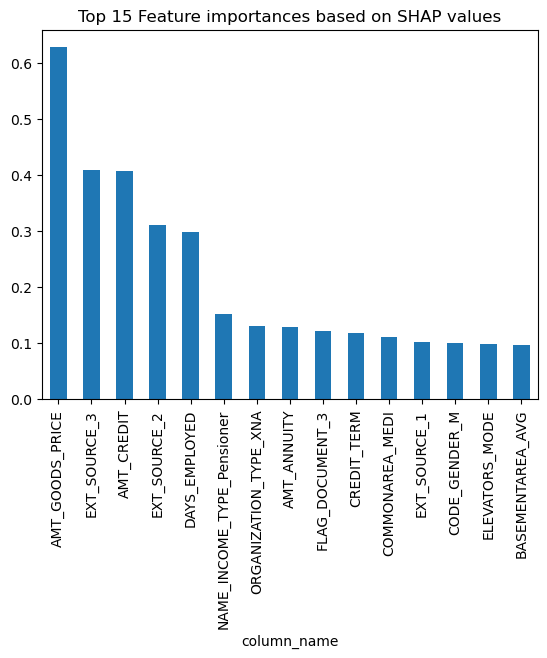

In [377]:
# Obtention de l'importance des fonctionnalités en fonction des valeurs SHAP
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_val.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)

top_features = importance_df.iloc[:15]
top_features.plot(kind='bar', x='column_name', y='shap_importance', legend=False)
plt.title('Top 15 Feature importances based on SHAP values')
plt.savefig('/Users/innakonar/Desktop/Project_7/shap_feature_importance.png', bbox_inches='tight')
plt.show()


In [376]:
# Serialize model
with open('best_model_filename.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)
# Serialize explainer
# with open('explainer.pkl', 'wb') as file:
#     pickle.dump(explainer, file)
with open('explainer.pkl', 'rb') as file:
    explainer = pickle.load(file)


In [368]:
df_predictions = pd.DataFrame(final_predictions, columns=["Prediction"])
df_predictions

Prediction
0               0
1               1
2               0
3               0
4               1
...           ...
48739           0
48740           0
48741           0
48742           0
48743           1

[48744 rows x 1 columns]

In [369]:
df_predictions.to_csv("predictions.csv", index=False)
